In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, roc_curve
from sklearn.inspection import permutation_importance

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy, Recall, Precision, TrueNegatives, TruePositives, FalseNegatives, FalsePositives

np.random.seed(113)

%config InlineBackend.figure_format = 'retina'

#### This notebook was used for training and evaluating classifiers which were later used for Oscar predictions:
##### 1. [PART 1](##-PART-1:-Predicting-which-movies-are-likely-to-become-Oscar-**contenders**): predicting Oscar contenders (any category)
##### 2. [PART 2](##-PART-2:-Predicting-which-movies-are-likely-to-become-Oscar-**winners**): predicting Oscar winners (any category)
##### 3. [PART 3](##-PART-3:-Predicting-which-movie-might-**get-nominated**-for-Best-Picture): predicting Best Picture conenders
##### 4. [PART 4](##-PART-4:-Predicting-which-movies-have-the-highest-chances-of-**winning**-Best-Picture): predicting Best Picture winners

***
### Setup

#### Display preferences

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
colors = ['#dbbd5a', '#d2ad32', '#ae8e25']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
cmap_name_ = 'golds'
golds = LinearSegmentedColormap.from_list(cmap_name_, colors, N=100)

colors = ['#fcfaf4', '#e8d596', '#dec267', '#d4af38', '#d4af38']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
cmap_n = 'golds_cm'
golds_cm = LinearSegmentedColormap.from_list(cmap_n, colors, N=100)

colors_ext = ['#f5edd3', '#ecddab', '#e4cd82', '#dbbd5a', '#d2ad32', '#ae8e25', '#866d1c', '#5e4c14', '#352b0b']  #shades of "gold", from lightest to darkest (with help from icolorpalette.com)
name = 'golds_ext'
golds_ext = LinearSegmentedColormap.from_list(name, colors_ext, N=100)

#### Reading in data

In [4]:
titles = pd.read_csv('../data/title_basics_1990_2020.csv', index_col = 'tconst')
movies = pd.read_csv('../data/movies_1990_2020_with_detail_oscars_complete.csv', index_col= 'tconst', low_memory=False)
movies_2020 = movies[movies['startYear']==2020] # the 2020 ceremony took place on 2/9/2020, so all movies made that year can be considered potential contenders for 2021 (release dates are susceptible to nans and thus less reliable than startYear)
movies = movies[movies['startYear']<2020]

In [5]:
X_vars_all = ['runtimeMinutes', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 
       'Warner Bros.', 'Universal Pictures', 'Columbia Pictures',
       'Paramount Pictures', 'Dreamworks Pictures', 'Walt Disney Pictures',
       'Miramax', 'Twentieth Century Fox', 'New Line Cinema', 'Focus Features',
       'Fox Searchlight Pictures', 'Touchstone Pictures',
       'Walt Disney Animation Studios', 'BBC Films', 'TriStar Pictures',
       'New Regency Productions', 'Fox 2000 Pictures', 'The Weinstein Company',
       'Annapurna Pictures', 'Castle Rock Entertainment',
        'oscars_post_release', 'US_open_WE', 'prev_Oscars', 'rel_USA', 'prev_Oscar_wins_nm', 'prev_Oscar_noms_nm', 'GG',
       'rel__aug', 'rel__dec', 'rel__feb', 'rel__jan', 'rel__jul', 'rel__jun',
       'rel__mar', 'rel__may', 'rel__nov', 'rel__oct', 'rel__sep',
             'budget_USD']

#### Baseline model class for binary classifications using only target variable as input

In [6]:
class BaselineModel:
  def __init__(self, dep_var):
    self.y = dep_var

  def predict(self):
    return [round(self.y.mean(),)]*len(self.y)

  def score(self):
    return accuracy_score(self.y, [round(self.y.mean(),)]*len(self.y))

#### Creating target labels for all tasks / classifiers

In [7]:
# 1. Any nomination: `Oscars` (in loaded data)

# 2. Any win:
movies['Oscar_winner'] = movies['o_wins'].apply(lambda x: np.where(x>0, 1, 0))

# 3. Best Picture nomination:
movies['best_pic'] = movies['picture_NW'].notna().astype(int)

# 4. Best Picture win:
movies['best_pic_win'] = (movies['picture_NW']=='W').astype(int)

#### Bootstrapping Oscars data to correct for class imbalances

In [8]:
movies_train, movies_test = train_test_split(movies, random_state = 113, stratify = movies[['Oscars', 'Oscar_winner', 'best_pic', 'best_pic_win']])

***

## PART 1: Predicting which movies are likely to become Oscar **contenders**

### 1.1. Baseline model

In [9]:
movies['Oscars'].value_counts(normalize= False)

0    174496
1      1199
Name: Oscars, dtype: int64

In [10]:
y = movies['Oscars']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9932 and recall of 0.0.


### 1.2. Bootstrapping and scaling the training data

In [11]:
movies_train_btstrp = pd.concat([movies_train, movies_train[movies_train['Oscars']==1].sample(n = 100000, replace = True, random_state=113)], axis = 0) # randomly resampling additional 100,000 titles with Oscar nominations or wins into the training set

movies_train_btstrp['Oscars'].value_counts(normalize=False)

0    130872
1    100899
Name: Oscars, dtype: int64

In [12]:
y_train = movies_train_btstrp['Oscars']
X_train = movies_train_btstrp[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['Oscars']

stan_nom = StandardScaler()
Z_train = stan_nom.fit_transform(X_train)
Z_test = stan_nom.transform(X_test)

In [125]:
pickle.dump(stan_nom, open('../pickles/stan_nom.p', 'wb')) #saving the scaler to apply to 2020 data for 2021 Oscars predictions

### 1.3. Logistic regression trained on bootstrapped data

#### 1.3.1 Fitting and scoring a classifier

In [13]:
lr_nom = LogisticRegression()
lr_nom.fit(Z_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(lr_nom.score(Z_train, y_train),4)} on train data and {round(lr_nom.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, lr_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, lr_nom.predict(X_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, lr_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, lr_nom.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(lr_nom, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(lr_nom, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(lr_nom, Z_test, y_test, scoring='precision').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.9069 on train data and 0.0638 on test data.
The same model has a recall score of 0.8446 on train data and 1.0 on test data.
The same model has a precision score of 0.9353 on train data and 1.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9949.
The model's recall calculated in 5-fold cross-validation is 0.4733.
The model's precision calculated in 5-fold cross-validation is 0.688.


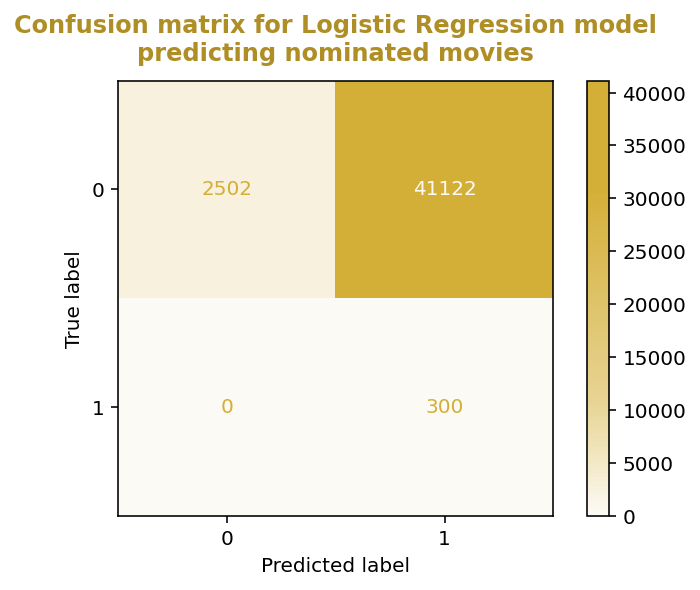

In [14]:
plot_confusion_matrix(lr_nom, X_test, y_test, cmap = golds_cm)
plt.title('Confusion matrix for Logistic Regression model\npredicting nominated movies', fontdict = {'color': '#ae8e25', 'fontsize': 12, 'fontweight': 'bold'}, pad = 10)
plt.savefig('../visualizations/cm_logr_nom.png', edgecolor='none')

#### 1.3.2 Viewing and interpreting coefficients for most predictive variables

In [15]:
logr_coefs = pd.DataFrame(index = X_vars_all, data =np.array([lr_nom.coef_[0], [np.e**lr_nom.coef_[0][i] for i in range(len(X_vars_all))]]).T, columns=['coef','e^coef'] )
logr_coefs['prob_contender'] = logr_coefs['e^coef']/(1+logr_coefs['e^coef'])
logr_coefs.sort_values('coef', ascending = False)[:10]

,coef,e^coef,prob_contender
GG,2.268794,9.667735,0.906259
budget_USD,1.665275,5.287128,0.840945
prev_Oscars,0.889413,2.433701,0.708769
Documentary,0.799307,2.223999,0.689826
runtimeMinutes,0.664015,1.942575,0.660162
rel_USA,0.626810,1.871630,0.651766
Drama,0.586834,1.798286,0.642638
rel__jan,0.531929,1.702213,0.629933
Animation,0.476974,1.611191,0.617033
rel__feb,0.422840,1.526290,0.604163


Of the five most predictive variables,`GG`, which indicates whether the movie was nominated / won a Golden Globe, is the most importand determinant, followed by budget and history of Oscar movies among the cast and crew.

In [16]:
pickle.dump(lr_nom, open('../pickles/lr_nom.p', 'wb'))

### 1.4. Random Forest Classification on bootstrapped data

In [17]:
#rfc_nom = pickle.load(open('../pickles/rfc_nom.p', 'rb'))
rfc_nom = RandomForestClassifier(max_depth = 20, criterion = 'gini', min_samples_leaf = 3)#, class_weight= {0: 0.01, 1: 0.99})
rfc_nom.fit(Z_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=3)

In [18]:
print(f"The Random Forest Classifier has an accuracy of {round(rfc_nom.score(Z_train, y_train),4)} on train data and {round(rfc_nom.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_nom.predict(Z_test)),4)} on test data.")
print(f"The model has a precision score of {round(precision_score(y_train, rfc_nom.predict(Z_train)),4)} on train data and {round(precision_score(y_test, rfc_nom.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_nom, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_nom, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(rfc_nom, Z_test, y_test, scoring='precision').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.989 on train data and 0.9888 on test data.
The same model has a recall score of 0.9855 on train data and 0.72 on test data.
The model has a precision score of 0.9893 on train data and 0.3473 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9954.
The model's recall calculated in 5-fold cross-validation is 0.4233.
The model's precision calculated in 5-fold cross-validation is 0.8219.


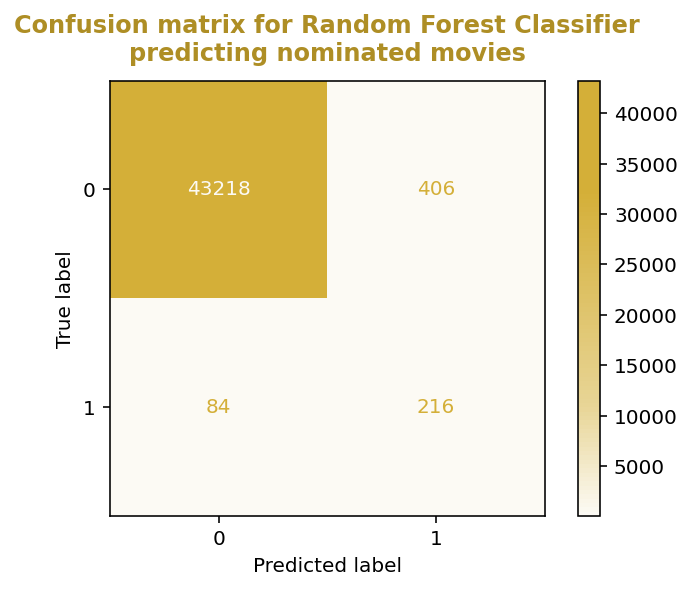

In [19]:
plot_confusion_matrix(rfc_nom, Z_test, y_test, cmap = golds_cm)
plt.title('Confusion matrix for Random Forest Classifier\npredicting nominated movies', fontdict = {'color': '#ae8e25', 'fontsize': 12, 'fontweight': 'bold'}, pad = 10);
plt.savefig('../visualizations/f_cm_rfc_nom.png', edgecolor='none')

In [20]:
pickle.dump(rfc_nom, open('../pickles/rfc_nom.p', 'wb'))

### 1.5. Adaboost Classifier on bootstrapped data

In [21]:
adalogr = AdaBoostClassifier(base_estimator = LogisticRegression(), n_estimators=100, learning_rate = 0.5, )
adalogr.fit(Z_train, y_train)

print(f"The AdaBoost Classifier using logistic regression has an accuracy of {round(adalogr.score(Z_train, y_train),4)} on train data and {round(adalogr.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, adalogr.predict(Z_train)),4)} on train data and {round(recall_score(y_test, adalogr.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, adalogr.predict(Z_train)),4)} on train data and {round(precision_score(y_test, adalogr.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(adalogr, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(adalogr, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(adalogr, Z_test, y_test, scoring='precision').mean(),4)}.")

The AdaBoost Classifier using logistic regression has an accuracy of 0.9015 on train data and 0.9536 on test data.
The same model has a recall score of 0.8326 on train data and 0.8533 on test data.
The same model has a precision score of 0.9339 on train data and 0.1137 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.995.
The model's recall calculated in 5-fold cross-validation is 0.49.
The model's precision calculated in 5-fold cross-validation is 0.6852.


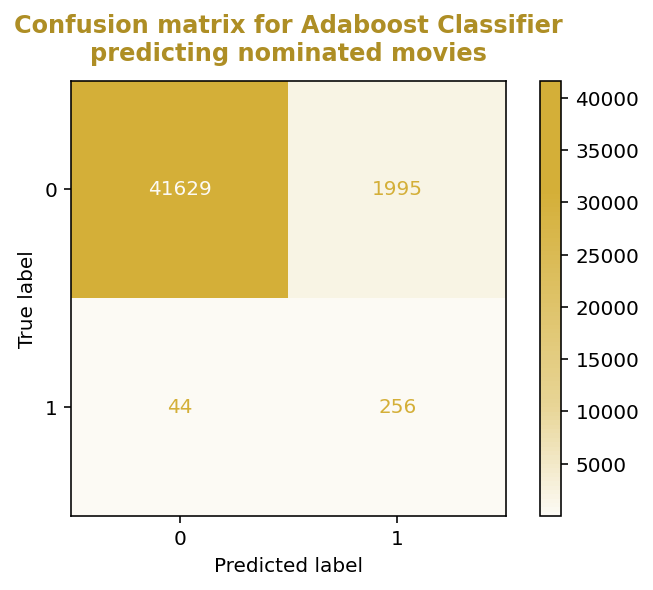

In [22]:
plot_confusion_matrix(adalogr, Z_test, y_test, cmap = golds_cm)
plt.title('Confusion matrix for Adaboost Classifier\npredicting nominated movies', fontdict = {'color': '#ae8e25', 'fontsize': 12, 'fontweight': 'bold'}, pad = 10);

In [23]:
#pickle.dump(adalogr, open('../pickles/adalogr_nom.p', 'wb'))

### 1.6. Support Vector Classifier on bootstrapped data

In [24]:
svc_nom = SVC(C = 0.5, class_weight = 'balanced')
svc_nom.fit(Z_train, y_train)

#svc_nom = pickle.load(open('../pickles/svc_nom.p', 'rb'))

SVC(C=0.5, class_weight='balanced')

In [25]:
print(f"The Support Vector Classifier has an accuracy of {round(svc_nom.score(Z_train, y_train),4)} on train data and {round(svc_nom.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, svc_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, svc_nom.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, svc_nom.predict(Z_train)),4)} on train data and {round(precision_score(y_test, svc_nom.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(svc_nom, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(svc_nom, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(svc_nom, Z_test, y_test, scoring='precision').mean(),4)}.")

The Support Vector Classifier has an accuracy of 0.959 on train data and 0.9631 on test data.
The same model has a recall score of 0.9508 on train data and 0.6933 on test data.
The same model has a precision score of 0.9549 on train data and 0.1197 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.977.
The model's recall calculated in 5-fold cross-validation is 0.4133.
The model's precision calculated in 5-fold cross-validation is 0.1293.


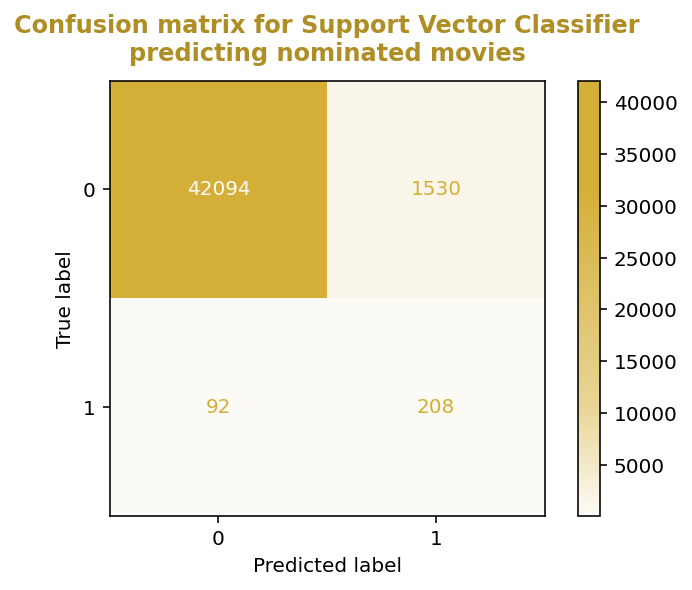

In [26]:
plot_confusion_matrix(svc_nom, Z_test, y_test, cmap = golds_cm)
plt.title('Confusion matrix for Support Vector Classifier\npredicting nominated movies', fontdict = {'color': '#ae8e25', 'fontsize': 12, 'fontweight': 'bold'}, pad = 10);
plt.savefig('../visualizations/cm_svc_nom.png', edgecolor='none')

In [27]:
pickle.dump(svc_nom, open('../pickles/svc_nom.p', 'wb'))

### 1.7. FFNN

In [28]:
def build_nn(train_features, hid_activation, dropout_rate, learn_rate, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    nn = Sequential()
    nn.add(layers.InputLayer(input_shape = (train_features.shape[1],)))
    nn.add(layers.Dense(512, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(512, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(256, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(256, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(64, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(64, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(32, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(16, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias))
    nn.compile(optimizer = Adam(learning_rate = learn_rate), loss = 'binary_crossentropy', metrics = ['AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return nn

In [29]:
initial_bias = np.log([y_train.sum()/len(y_train)])

In [30]:
#mod_bias = tf.keras.initializers.Constant(initial_bias)
nn_nom = build_nn(Z_train, 'relu', 0.2, 0.001, output_bias = initial_bias)

nn_nom.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               32768     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6

In [31]:
zero_wght = len(y_train)/(2*len(y_train[y_train == 0]))
one_wght = len(y_train)/(2*len(y_train[y_train == 1]))

In [32]:
es = EarlyStopping(monitor = 'val_auc', patience = 10, mode = 'max', restore_best_weights = True)

In [33]:
history = nn_nom.fit(Z_train, y_train, validation_data=(Z_test, y_test), callbacks = es, epochs = 100, class_weight={0: zero_wght, 1: one_wght}, workers = 3)

Epoch 1/100
7243/7243 [==============================] - 41s 5ms/step - loss: 0.2027 - auc: 0.9723 - true_positives: 46751.7079 - true_negatives: 61374.7111 - false_positives: 4046.5098 - false_negatives: 3747.0654 - val_loss: 0.1247 - val_auc: 0.9187 - val_true_positives: 236.0000 - val_true_negatives: 41513.0000 - val_false_positives: 2111.0000 - val_false_negatives: 64.000081.9289 - false_positives: 4023.5681 - false_negatives: 3734
Epoch 2/100
7243/7243 [==============================] - 40s 5ms/step - loss: 0.0995 - auc: 0.9933 - true_positives: 49132.2105 - true_negatives: 62567.0787 - false_positives: 2816.7334 - false_negatives: 1403.9716 - val_loss: 0.1102 - val_auc: 0.9111 - val_true_positives: 233.0000 - val_true_negatives: 42207.0000 - val_false_positives: 1417.0000 - val_false_negatives: 67.0000
Epoch 3/100
7243/7243 [==============================] - 40s 6ms/step - loss: 0.0845 - auc: 0.9947 - true_positives: 49553.2646 - true_negatives: 62872.6476 - false_positives: 2418

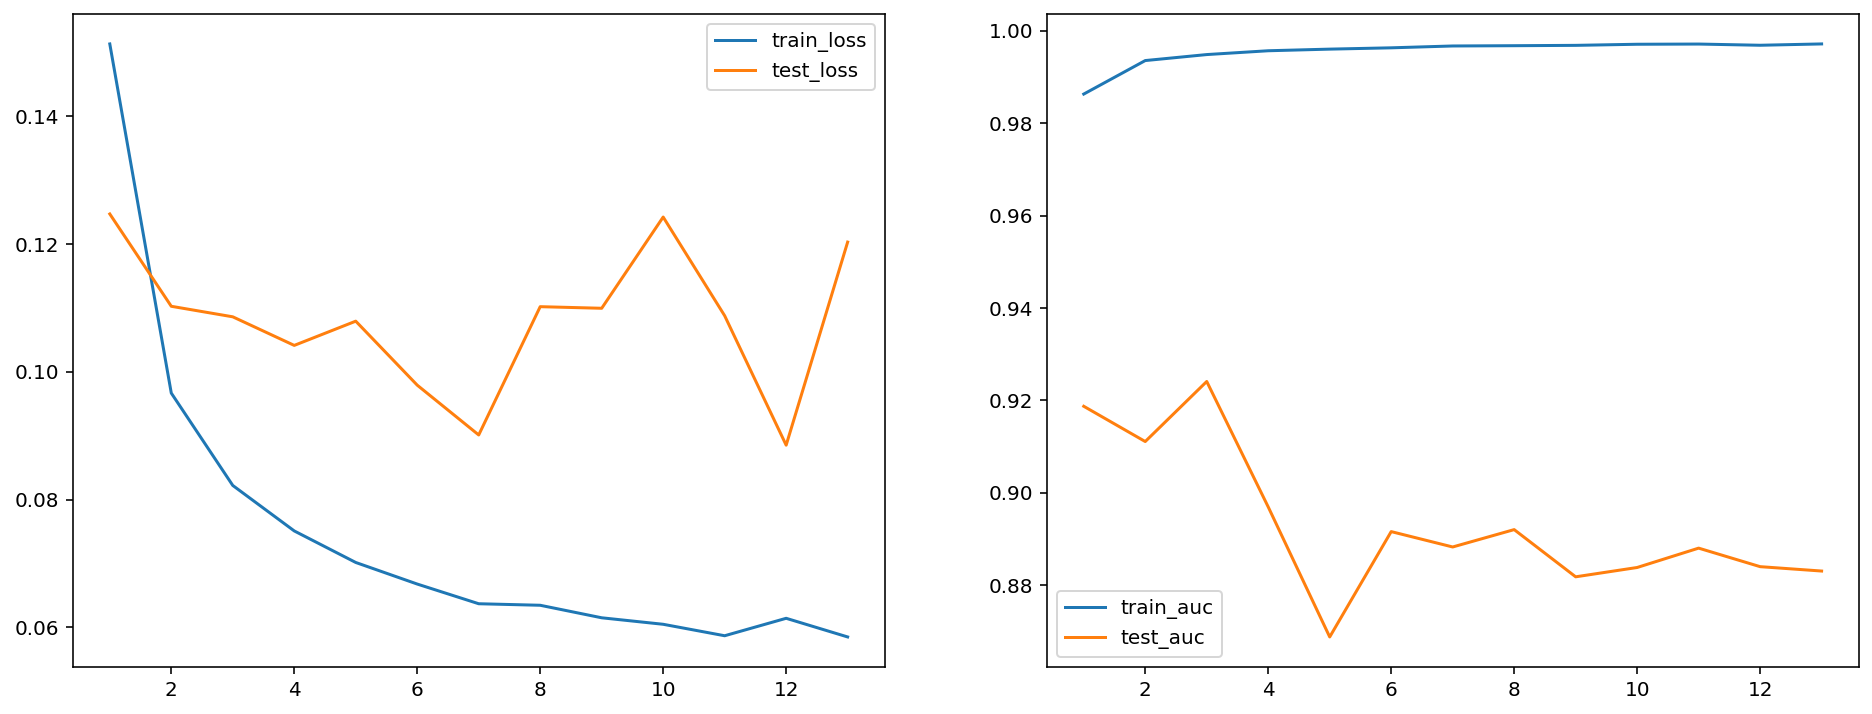

In [34]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label = 'test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['auc'])+1), history.history['auc'], label = 'train_auc')
plt.plot(range(1, len(history.history['auc'])+1), history.history['val_auc'], label = 'test_auc')
plt.legend();

In [35]:
p = 0.5

test_acc = Accuracy()
test_acc.update_state(y_test, (nn_nom.predict(Z_test)>= p).astype(int))
train_acc = Accuracy()
train_acc.update_state(y_train, (nn_nom.predict(Z_train)>= p).astype(int))

test_rec = Recall()
test_rec.update_state(y_test, (nn_nom.predict(Z_test)>=p).astype(int))
train_rec = Recall()
train_rec.update_state(y_train, (nn_nom.predict(Z_train)>=p).astype(int))

test_prec = Precision()
test_prec.update_state(y_test, (nn_nom.predict(Z_test)>=p).astype(int))
train_prec = Precision()
train_prec.update_state(y_train, (nn_nom.predict(Z_train)>=p).astype(int))

#nn_nom.predict(Z_test, batch_size= len(y_test)).astype(int)).result().numpy()

In [36]:
print(f"The Neural Network Classifier has an accuracy of {round((train_acc.result().numpy()),4)} on train data and {round((test_acc.result().numpy()),4)} on test data.")
print(f"The same model has a recall score of {round(train_rec.result().numpy(),4)} on train data and {round(test_rec.result().numpy(),4)} on test data.")
print(f"The model has a precision score of {round(train_prec.result().numpy(),4)} on train data and {round(test_prec.result().numpy(),4)} on test data.")

#print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring = 'Accuracy').mean(),4)}.")
#print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Recall').mean(),4)}.")
#print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Precision').mean(),4)}.")

The Neural Network Classifier has an accuracy of 0.9729999899864197 on train data and 0.9620000123977661 on test data.
The same model has a recall score of 0.9836000204086304 on train data and 0.7533000111579895 on test data.
The model has a precision score of 0.9556000232696533 on train data and 0.1242000013589859 on test data.


In [37]:
nn_nom.save('../models/nn_nom.h5')

In [38]:
nn_nom = tf.keras.models.load_model('../models/nn_nom.h5')

In [39]:
# borrowed from tensorflow documentation
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs,)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,60])
    plt.ylim([80,100.5])
    plt.grid(True, linestyle = '--', linewidth = 1, color = 'gray')
    ax = plt.gca()
    #ax.set_aspect('equal')

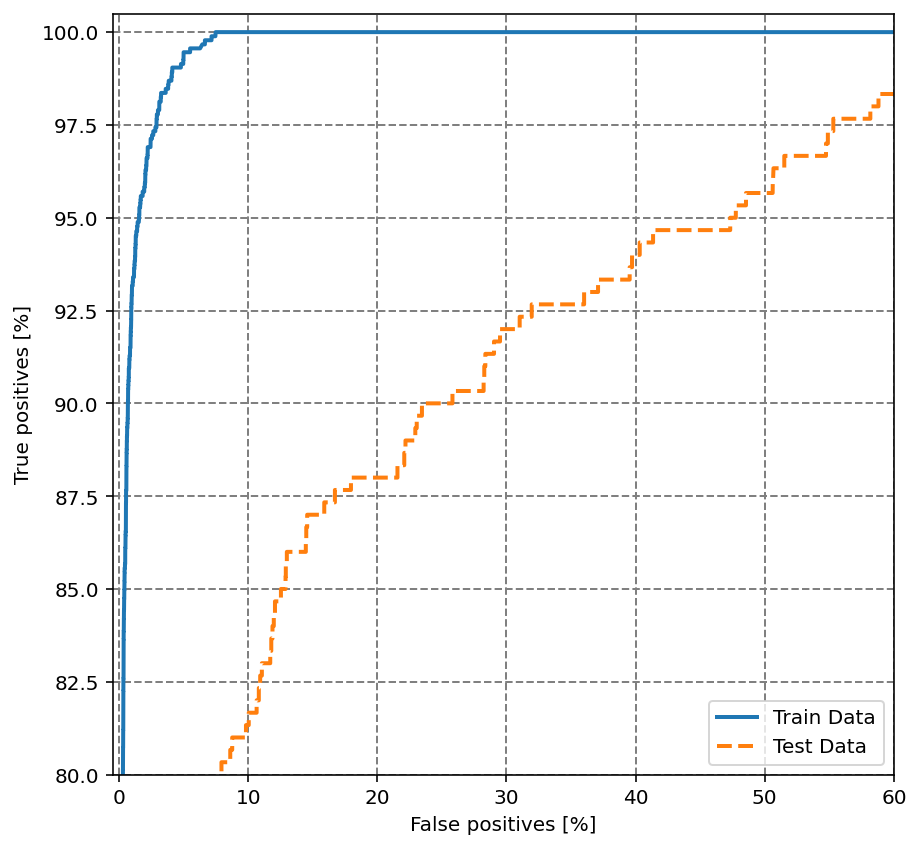

In [40]:
plt.figure(figsize = (7,7))
plot_roc("Train Data", y_train, nn_nom.predict(Z_train))
plot_roc("Test Data", y_test, nn_nom.predict(Z_test), linestyle='--')
plt.legend(loc='lower right');

In [41]:
threshold = 0.5
tp = TruePositives()
for i in range(100):
    tp.update_state(y_train, (nn_nom.predict(Z_train) >= threshold + i* 0.01)) # incrementing threshold by 0.05 and checking tp
    if tp.result().numpy()/y_train.sum() >= 0.8 and tp.result().numpy()/y_train.sum() < 0.81:
        print(f"The threshold corresponding to tp = 80 is approx. {round(threshold + i*0.05,2)}")
        exit()

In [128]:
def plot_cm(labels, predictions, threshold, pos_class):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap = golds_cm)
    plt.title('Confusion matrix @{:.2f}'.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print(f'Correctly identified as Not {pos_class} (True Negatives): ', cm[0][0])
    print(f'Incorectly identified as {pos_class} (False Positives): ', cm[0][1])
    print(f'Incorectly identified as Not {pos_class} (False Negatives): ', cm[1][0])
    print(f'Correctly identified as {pos_class} (True Positives): ', cm[1][1])
    print('Total Nominees: ', np.sum(cm[1]))

Correctly identified as Not Nominees (True Negatives):  42031
Incorectly identified as Nominees (False Positives):  1593
Incorectly identified as Not Nominees (False Negatives):  74
Correctly identified as Nominees (True Positives):  226
Total Nominees:  300


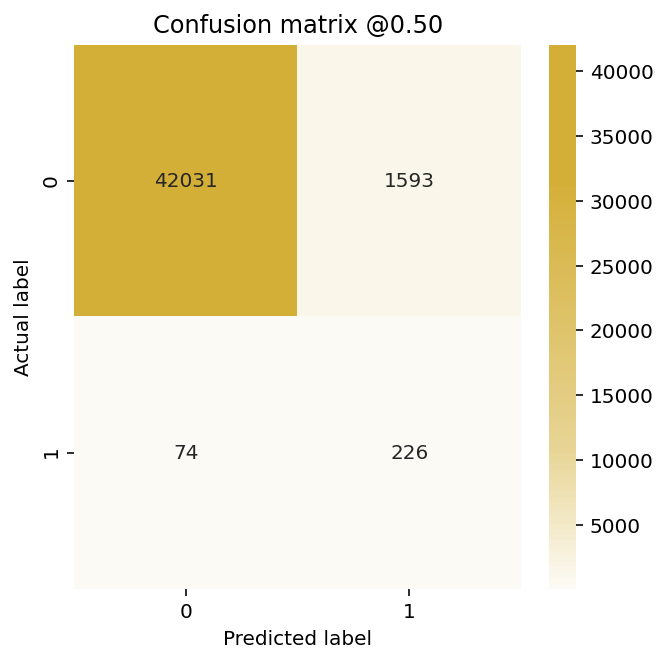

In [43]:
plot_cm(y_test, nn_nom.predict(Z_test), 0.5, 'Nominees')

### 1.8. Voting Classifier using previously trained Random Forest Classifier, Support Vector Classifier, and Logistic Regression

In [51]:
vote_nom = VotingClassifier(estimators=[('rf', rfc_nom), ('sv', svc_nom), ('lr', lr_nom)])
vote_nom.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(vote_nom.score(Z_train, y_train),4)} on train data and {round(vote_nom.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, vote_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, vote_nom.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, vote_nom.predict(Z_train)),4)} on train data and {round(precision_score(y_test, vote_nom.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(vote_nom, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(vote_nom, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(vote_nom, Z_test, y_test, scoring='precision').mean(),4)}.")

The Voting Classifier has an accuracy of 0.9673 on train data and 0.9811 on test data.
The same model has a recall score of 0.9461 on train data and 0.77 on test data.
The same model has a precision score of 0.9781 on train data and 0.2329 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9952.
The model's recall calculated in 5-fold cross-validation is 0.46.
The model's precision calculated in 5-fold cross-validation is 0.729.


In [52]:
pickle.dump(vote_nom, open('../pickles/vote_nom.p', 'wb'))

### 1.9. Stacking Classifier using previously trained Random Forest Classifier, Support Vector Classifier and Neural Network

In [53]:
stack_nom = StackingClassifier(estimators=[('rf', rfc_nom), ('sv', svc_nom), ('lr', lr_nom)])
stack_nom.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(stack_nom.score(Z_train, y_train),4)} on train data and {round(stack_nom.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, stack_nom.predict(Z_train)),4)} on train data and {round(recall_score(y_test, stack_nom.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, stack_nom.predict(Z_train)),4)} on train data and {round(precision_score(y_test, stack_nom.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(stack_nom, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(stack_nom, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(stack_nom, Z_test, y_test, scoring='precision').mean(),4)}.")

The Voting Classifier has an accuracy of 0.9904 on train data and 0.9893 on test data.
The same model has a recall score of 0.9877 on train data and 0.6667 on test data.
The same model has a precision score of 0.9903 on train data and 0.3515 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9953.
The model's recall calculated in 5-fold cross-validation is 0.51.
The model's precision calculated in 5-fold cross-validation is 0.7234.


In [54]:
pickle.dump(stack_nom, open('../pickles/stack_nom.p', 'wb'))

### 1.10. Picking the best prediction algorightm based on precision and recall

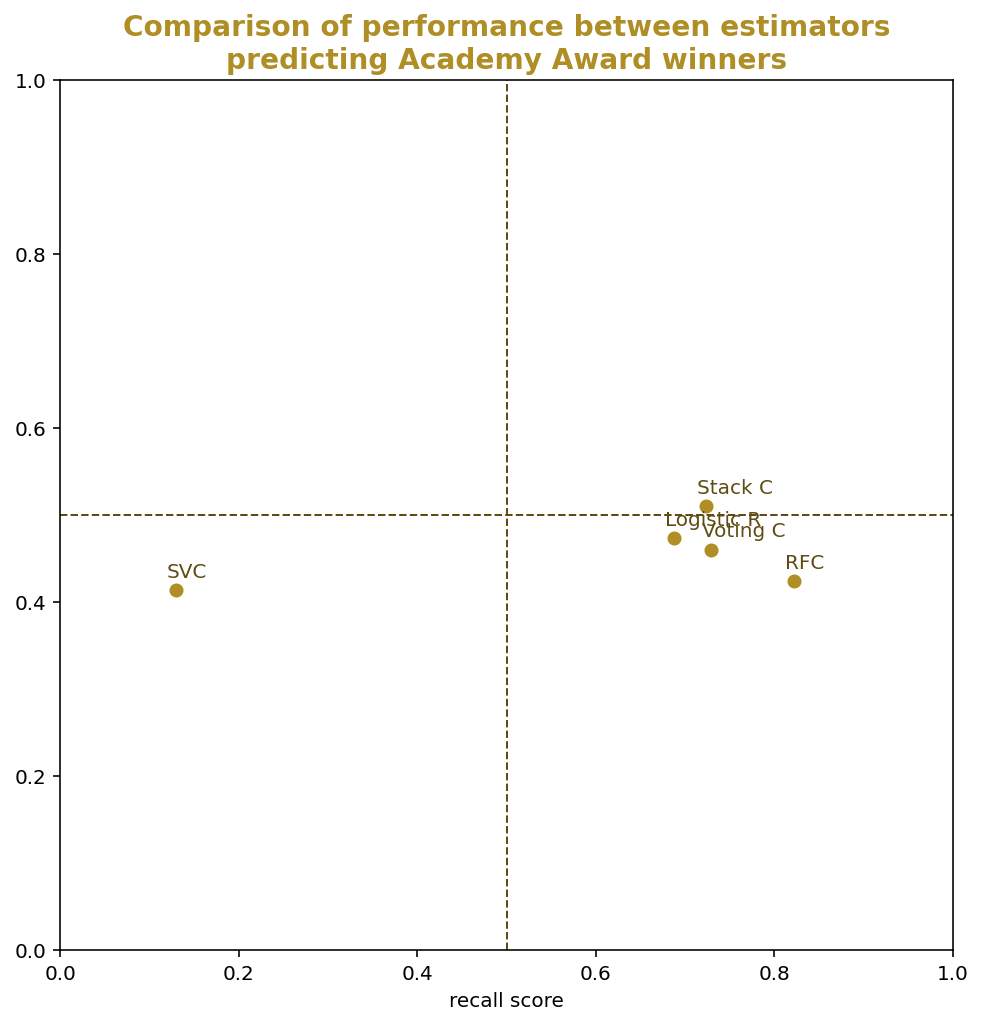

In [123]:
ests_nom = [vote_nom, stack_nom, lr_nom, svc_nom, rfc_nom]
ests_nom_labels = ['Voting C', 'Stack C', 'Logistic R', 'SVC', 'RFC']
prec_nom = [0.729, 0.7234, 0.688, 0.1293, 0.8219]
rec_nom = [0.46, 0.51, 0.4733, 0.4133, 0.4233]

plt.figure(figsize = (8,8))
plt.title('Comparison of performance between estimators\npredicting Academy Award winners', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#ae8e25'})
plt.scatter(prec_nom, rec_nom, c = '#ae8e25')
plt.xlim(0,1)
plt.xlabel('precision score')
plt.ylim(0,1)
plt.xlabel('recall score')
plt.axhline(0.5, ls = '--', lw = 1, c = '#5e4c14')
plt.axvline(0.5, ls = '--', lw = 1, c = '#5e4c14')
for i in range(len(ests_nom)):
    plt.text(prec_nom[i]-0.01, rec_nom[i]+0.015, ests_nom_labels[i], c = '#5e4c14')

***

## PART 2: Predicting which movies are likely to become Oscar **winners**

### 2.1. Baseline model

In [30]:
movies['Oscar_winner'].value_counts(normalize= False)

0    175462
1       233
Name: Oscar_winner, dtype: int64

In [31]:
y = movies['Oscar_winner']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9987 and recall of 0.0.


### 2.2. Bootstrapping and scaling the training data

In [55]:
movies_train_btstrp = pd.concat([movies_train, movies_train[movies_train['Oscar_winner']==1].sample(n = 100000, replace = True, random_state=113)], axis = 0) # randomly resampling additional 100,000 titles with Oscar nominations or wins into the training set
movies_train_btstrp['Oscar_winner'].value_counts(normalize=False)

0    131596
1    100175
Name: Oscar_winner, dtype: int64

In [56]:
y_train = movies_train_btstrp['Oscar_winner']
X_train = movies_train_btstrp[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['Oscar_winner']

stan_win = StandardScaler()
Z_train = stan_win.fit_transform(X_train)
Z_test = stan_win.transform(X_test)

In [126]:
pickle.dump(stan_win, open('../pickles/stan_win.p', 'wb')) #saving the scaler to apply to 2020 data for 2021 Oscars predictions

### 2.3. Logistic regression on bootstrapped data

In [57]:
lr_win = LogisticRegression()
lr_win.fit(X_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(lr_win.score(X_train, y_train),4)} on train data and {round(lr_win.score(X_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, lr_win.predict(X_train)),4)} on train data and {round(recall_score(y_test, lr_win.predict(X_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, lr_win.predict(X_train)),4)} on train data and {round(precision_score(y_test, lr_win.predict(X_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(lr_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(lr_win, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(lr_win, Z_test, y_test, scoring='precision').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.8978 on train data and 0.8438 on test data.
The same model has a recall score of 0.9658 on train data and 0.9828 on test data.
The same model has a precision score of 0.8269 on train data and 0.0082 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9985.
The model's recall calculated in 5-fold cross-validation is 0.2364.
The model's precision calculated in 5-fold cross-validation is 0.3917.


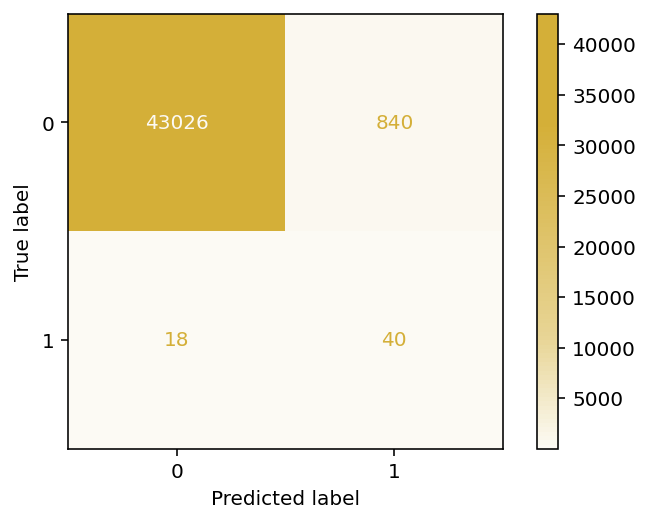

In [58]:
plot_confusion_matrix(lr_win, Z_test, y_test, cmap = golds_cm);

In [59]:
pickle.dump(lr_win, open('../pickles/lr_win.p', 'wb'))

### 2.4. Random Forest Classification on bootstrapped data

#### 2.4.1 Fitting and evaluating the classifier

In [60]:
rfc_win = RandomForestClassifier(max_depth = 20, criterion = 'gini', min_samples_leaf = 3, class_weight= {0: 0.001, 1: 0.999})
rfc_win.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc_win.score(Z_train, y_train),4)} on train data and {round(rfc_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_win.predict(Z_test)),4)} on test data.")
print(f"The  model has a precision score of {round(precision_score(y_train, rfc_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, rfc_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_win, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(rfc_win, Z_test, y_test, scoring='precision').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9969 on train data and 0.9941 on test data.
The same model has a recall score of 1.0 on train data and 0.7759 on test data.
The  model has a precision score of 0.9928 on train data and 0.1557 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9982.
The model's recall calculated in 5-fold cross-validation is 0.5894.
The model's precision calculated in 5-fold cross-validation is 0.4315.


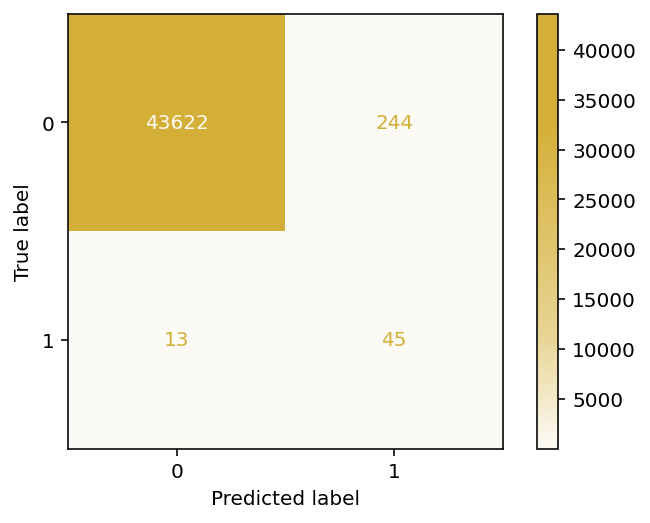

In [61]:
plot_confusion_matrix(rfc_win, Z_test, y_test, cmap = golds_cm);

In [62]:
pickle.dump(rfc_win, open('../pickles/rfc_win.p', 'wb'))

In [36]:
#rfc_win = pickle.load(open('../pickles/rfc_win.p', 'rb'))

#### 2.4.2 Viewing and interpreting feature importance ratings

In [63]:
perm_imp = permutation_importance(rfc_win, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X_train.columns, columns = ['permutation_imp'])

rfc_win_features = pd.DataFrame(index = X_train.columns, data = rfc_win.feature_importances_, columns=['feature_importance'])
rfc_win_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_win_features = rfc_win_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_win_features[:10]

,feature_importance,permutation_imp
runtimeMinutes,0.219957,-0.002336
budget_USD,0.211547,-0.003889
US_open_WE,0.113309,-0.000528
GG,0.109961,-0.001084
rel_USA,0.085608,-0.002527
Documentary,0.069854,-0.001043
Drama,0.026068,-0.000806
oscars_post_release,0.023275,-0.000496
prev_Oscars,0.016967,-0.003092
Comedy,0.011709,0.000127


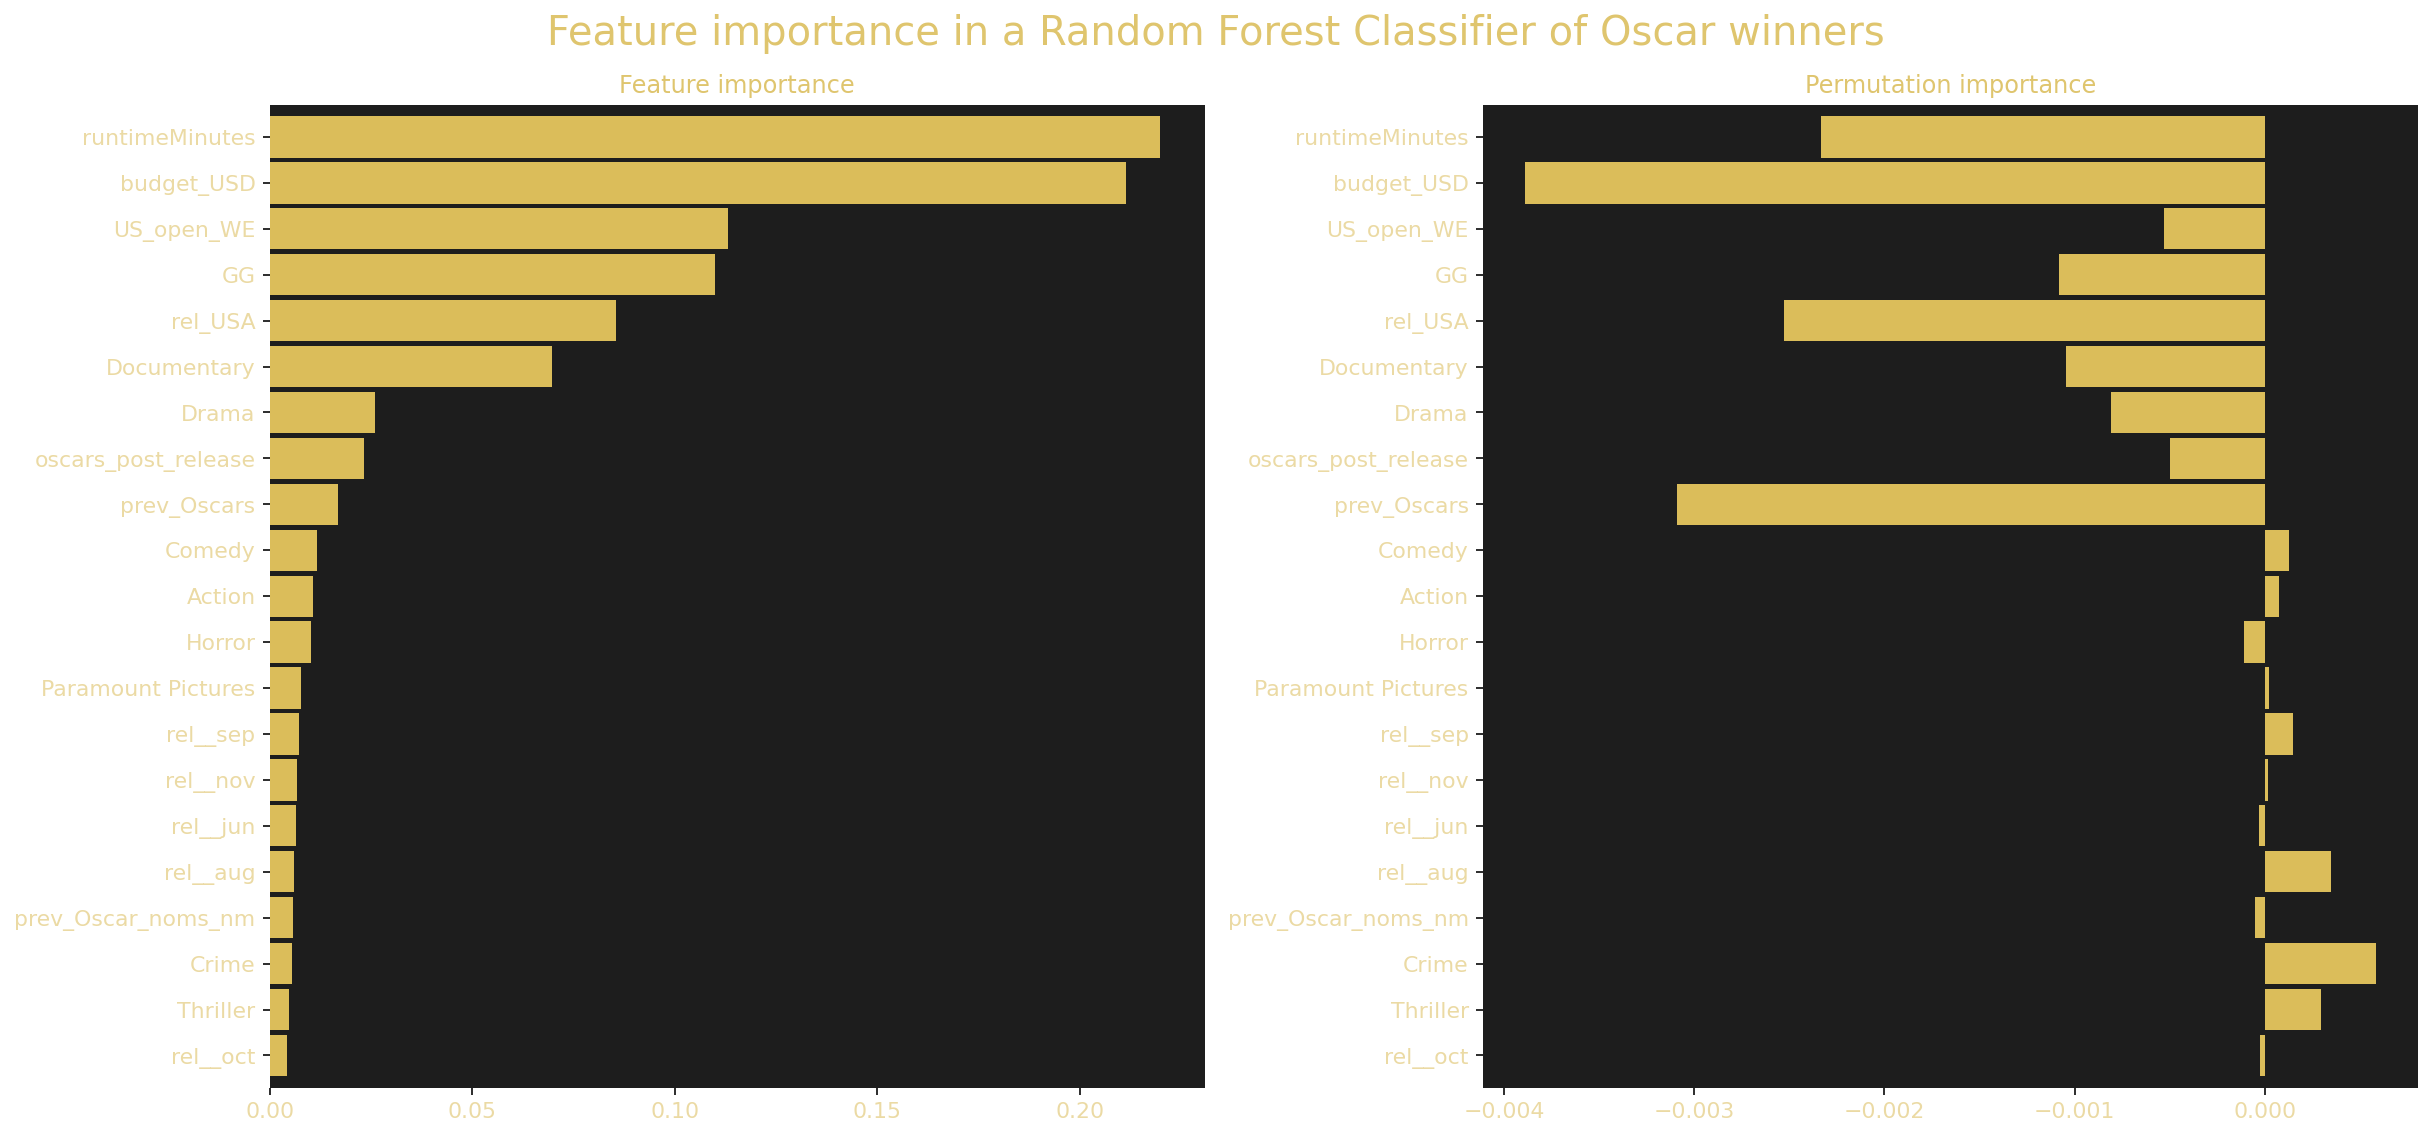

In [64]:
plt.figure(figsize=(17,8));
plt.rcParams['text.color'] = '#dfc56e'
plt.suptitle('Feature importance in a Random Forest Classifier of Oscar winners',fontsize =20);
plt.subplot(1,2,1);
fig1 = rfc_win_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9)
fig1.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.subplot(1,2,2);
fig2 = rfc_win_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
fig2.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_win.png',facecolor=fig1.get_facecolor(), edgecolor='none')

In [65]:
pickle.dump(rfc_win, open('../pickles/rfc_win.p', 'wb'))

### 2.5. Support Vector Classifier on bootstrapped data

In [66]:
svc_win = SVC(C = 0.01, class_weight = 'balanced')
svc_win.fit(Z_train, y_train)

#svc_win = pickle.load(open('../pickles/svc_win.p', 'rb'))

print(f"The Support Vector Classifier has an accuracy of {round(svc_win.score(Z_train, y_train),4)} on train data and {round(svc_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, svc_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, svc_win.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, svc_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, svc_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(svc_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(svc_win, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(svc_win, Z_test, y_test, scoring='precision').mean(),4)}.")

The Support Vector Classifier has an accuracy of 0.9924 on train data and 0.9862 on test data.
The same model has a recall score of 1.0 on train data and 0.9828 on test data.
The same model has a precision score of 0.9828 on train data and 0.0861 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9847.
The model's recall calculated in 5-fold cross-validation is 0.9667.
The model's precision calculated in 5-fold cross-validation is 0.0773.


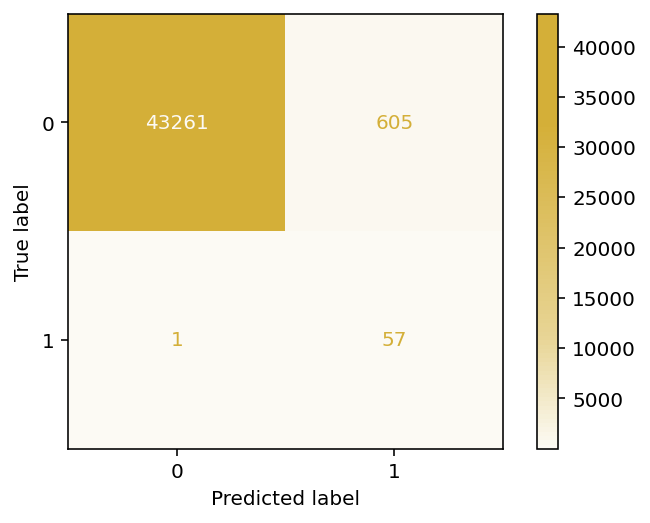

In [67]:
plot_confusion_matrix(svc_win, Z_test, y_test, cmap = golds_cm);
#plt.savefig('../visualizations/cm_svc_win.png',facecolor=fig.get_facecolor(), edgecolor='none')

In [68]:
pickle.dump(svc_win, open('../pickles/svc_win.p', 'wb'))

### 2.6. FFNN

In [96]:
def build_nn(train_features, hid_activation, dropout_rate, learn_rate, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    nn = Sequential()
    nn.add(layers.InputLayer(input_shape = (train_features.shape[1],)))
    nn.add(layers.Dense(512, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(512, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(256, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(256, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(64, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(64, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(32, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(16, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias))
    nn.compile(optimizer = Adam(learning_rate = learn_rate), loss = 'binary_crossentropy', metrics = ['AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return nn

In [97]:
initial_bias = np.log([y_train.sum()/len(y_train)])

In [98]:
nn_win = build_nn(Z_train, 'relu', 0.2, 0.001, output_bias = initial_bias)
nn_win.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               32768     
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [99]:
zero_wght = len(y_train)/(2*len(y_train[y_train == 0]))
one_wght = len(y_train)/(2*len(y_train[y_train == 1]))

In [100]:
es = EarlyStopping(monitor = 'val_auc', patience = 10, mode = 'max', restore_best_weights = True)

In [101]:
history = nn_win.fit(Z_train, y_train, validation_data=(Z_test, y_test), callbacks = es, epochs = 100, class_weight={0: zero_wght, 1: one_wght}, workers = 3)

Epoch 1/100
7243/7243 [==============================] - 35s 4ms/step - loss: 0.0392 - auc: 0.9972 - true_positives: 50031.2021 - true_negatives: 65300.0037 - false_positives: 421.8923 - false_negatives: 166.8961 - val_loss: 0.0167 - val_auc: 0.9207 - val_true_positives: 38.0000 - val_true_negatives: 43748.0000 - val_false_positives: 118.0000 - val_false_negatives: 20.0000
Epoch 2/100
7243/7243 [==============================] - 34s 5ms/step - loss: 0.0093 - auc: 0.9994 - true_positives: 49923.1420 - true_negatives: 65815.7312 - false_positives: 152.6340 - false_negatives: 28.4869 - val_loss: 0.0215 - val_auc: 0.7919 - val_true_positives: 29.0000 - val_true_negatives: 43780.0000 - val_false_positives: 86.0000 - val_false_negatives: 29.0000
Epoch 3/100
7243/7243 [==============================] - 31s 4ms/step - loss: 0.0065 - auc: 0.9996 - true_positives: 50243.7871 - true_negatives: 65533.1491 - false_positives: 122.4640 - false_negatives: 20.5940 - val_loss: 0.0275 - val_auc: 0.8177 -

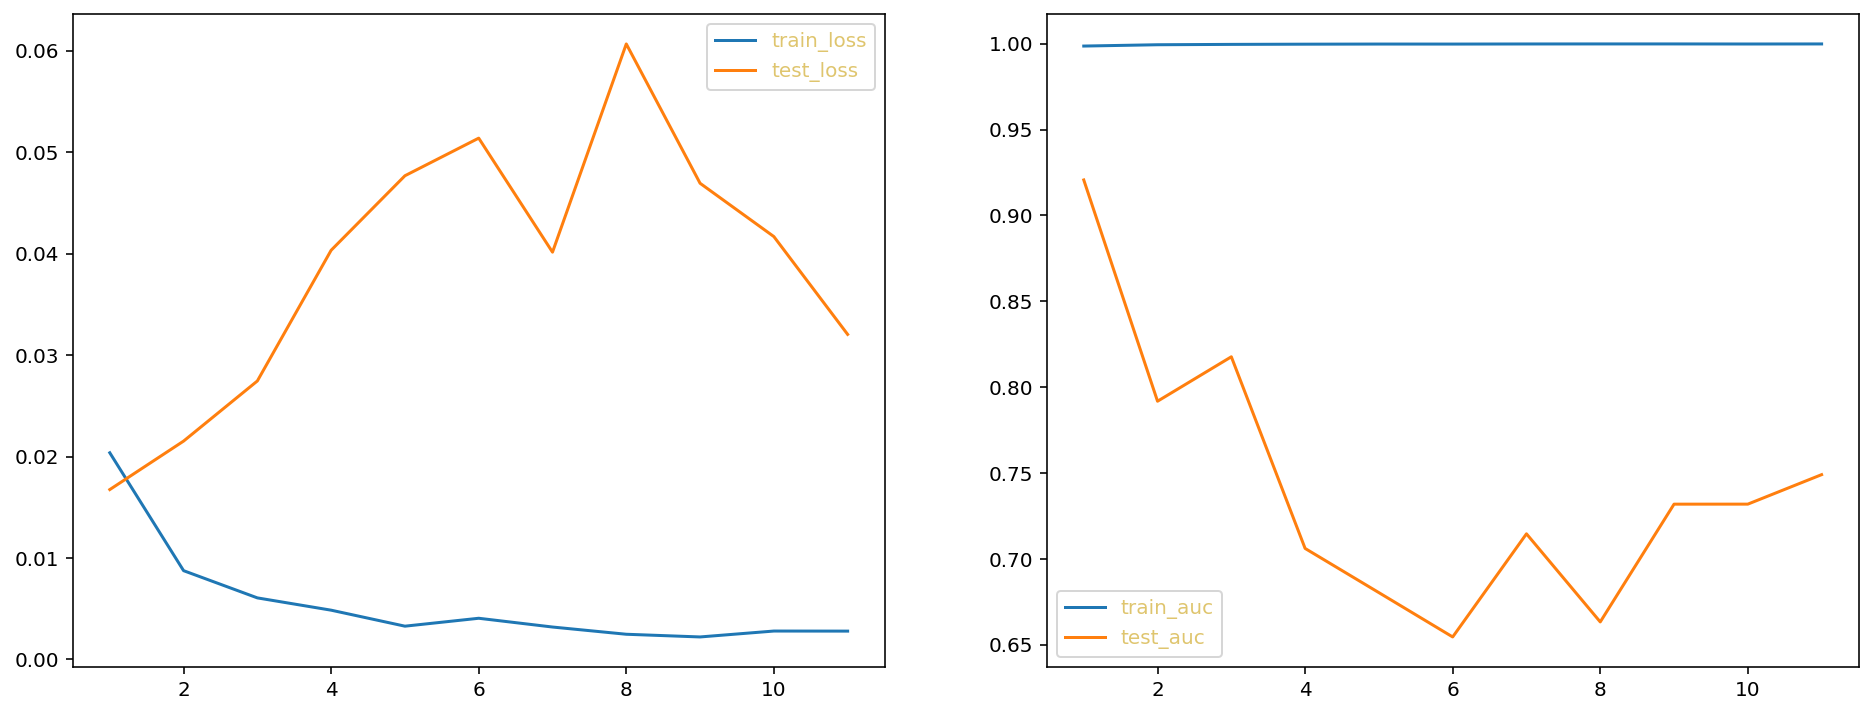

In [102]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label = 'test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['auc'])+1), history.history['auc'], label = 'train_auc')
plt.plot(range(1, len(history.history['auc'])+1), history.history['val_auc'], label = 'test_auc')
plt.legend();

In [103]:
p = 0.5

test_acc = Accuracy()
test_acc.update_state(y_test, (nn_win.predict(Z_test)>= p).astype(int))
train_acc = Accuracy()
train_acc.update_state(y_train, (nn_win.predict(Z_train)>= p).astype(int))

test_rec = Recall()
test_rec.update_state(y_test, (nn_win.predict(Z_test)>=p).astype(int))
train_rec = Recall()
train_rec.update_state(y_train, (nn_win.predict(Z_train)>=p).astype(int))

test_prec = Precision()
test_prec.update_state(y_test, (nn_win.predict(Z_test)>=p).astype(int))
train_prec = Precision()
train_prec.update_state(y_train, (nn_win.predict(Z_train)>=p).astype(int))

#nn_nom.predict(Z_test, batch_size= len(y_test)).astype(int)).result().numpy()

In [104]:
print(f"The Neural Network Classifier has an accuracy of {round((train_acc.result().numpy()),4)} on train data and {round((test_acc.result().numpy()),4)} on test data.")
print(f"The same model has a recall score of {round(train_rec.result().numpy(),4)} on train data and {round(test_rec.result().numpy(),4)} on test data.")
print(f"The model has a precision score of {round(train_prec.result().numpy(),4)} on train data and {round(test_prec.result().numpy(),4)} on test data.")

#print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring = 'Accuracy').mean(),4)}.")
#print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Recall').mean(),4)}.")
#print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Precision').mean(),4)}.")

The Neural Network Classifier has an accuracy of 0.9988999962806702 on train data and 0.9969000220298767 on test data.
The same model has a recall score of 1.0 on train data and 0.6552000045776367 on test data.
The model has a precision score of 0.9976000189781189 on train data and 0.243599995970726 on test data.


In [30]:
#nn_win.save('../models/nn_win.h5')

In [44]:
#nn_win = tf.keras.models.load_model('../models/nn_win.h5')

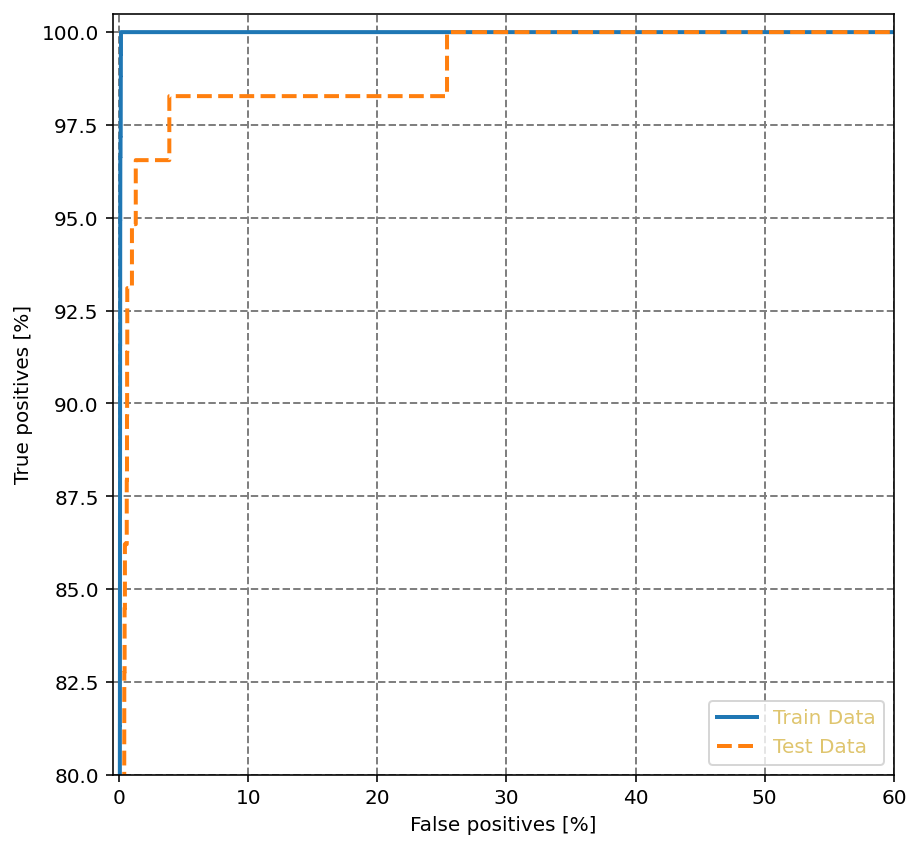

In [105]:
plt.figure(figsize = (7,7))
plot_roc("Train Data", y_train, nn_win.predict(Z_train))
plot_roc("Test Data", y_test, nn_win.predict(Z_test), linestyle='--')
plt.legend(loc='lower right');

Correctly identified as Not Winners (True Negatives):  43748
Incorectly identified as Winners (False Positives):  118
Incorectly identified as Not Winners (False Negatives):  20
Correctly identified as Winners (True Positives):  38
Total Nominees:  58


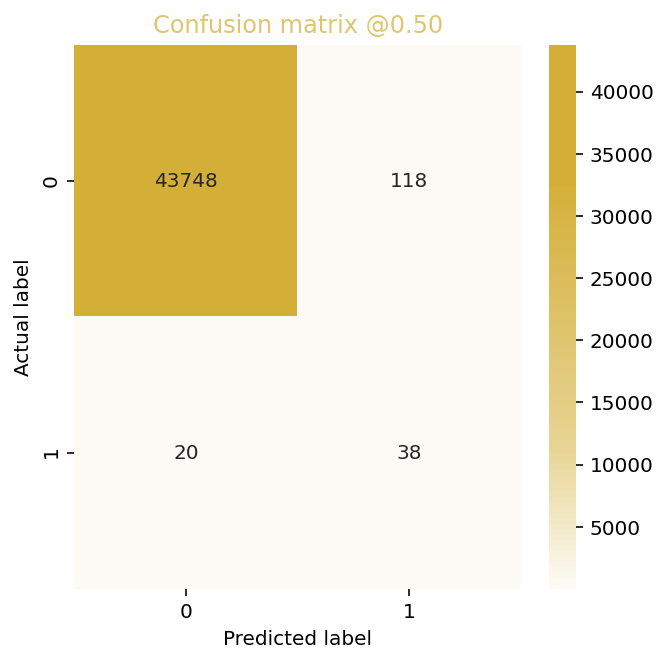

In [107]:
plot_cm(y_test, nn_win.predict(Z_test), 0.5, 'Winners')

### 2.6. Voting Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [69]:
vote_win = VotingClassifier(estimators=[('rf', rfc_win), ('sv', svc_win), ('lr', lr_win)], weights = [0.4, 0.5, 0.1], )
vote_win.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(vote_win.score(Z_train, y_train),4)} on train data and {round(vote_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, vote_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, vote_win.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, vote_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, vote_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(vote_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(vote_win, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(vote_win, Z_test, y_test, scoring='precision').mean(),4)}.")

/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The Voting Classifier has an accuracy of 0.9959 on train data and 0.9928 on test data.
The same model has a recall score of 1.0 on train data and 0.9655 on test data.
The same model has a precision score of 0.9907 on train data and 0.1518 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9981.
The model's recall calculated in 5-fold cross-validation is 0.6561.
The model's precision calculated in 5-fold cross-validation is 0.445.


In [70]:
pickle.dump(vote_win, open('../pickles/vote_win.p', 'wb'))

### 2.7. Stacking Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [114]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [71]:
stack_win = StackingClassifier(estimators=[('rf', rfc_win), ('sv', svc_win), ('lr', lr_win)])
stack_win.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(stack_win.score(Z_train, y_train),4)} on train data and {round(stack_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, stack_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, stack_win.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, stack_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, stack_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(stack_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(stack_win, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(stack_win, Z_test, y_test, scoring='precision').mean(),4)}.")

/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/martalew/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

The Voting Classifier has an accuracy of 0.9996 on train data and 0.9982 on test data.
The same model has a recall score of 1.0 on train data and 0.5172 on test data.
The same model has a precision score of 0.9991 on train data and 0.3704 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9985.
The model's recall calculated in 5-fold cross-validation is 0.1697.
The model's precision calculated in 5-fold cross-validation is 0.25.


In [72]:
pickle.dump(stack_win, open('../pickles/stack_win.p', 'wb'))

### 2.8. Picking the best prediction algorightm based on precision and recall

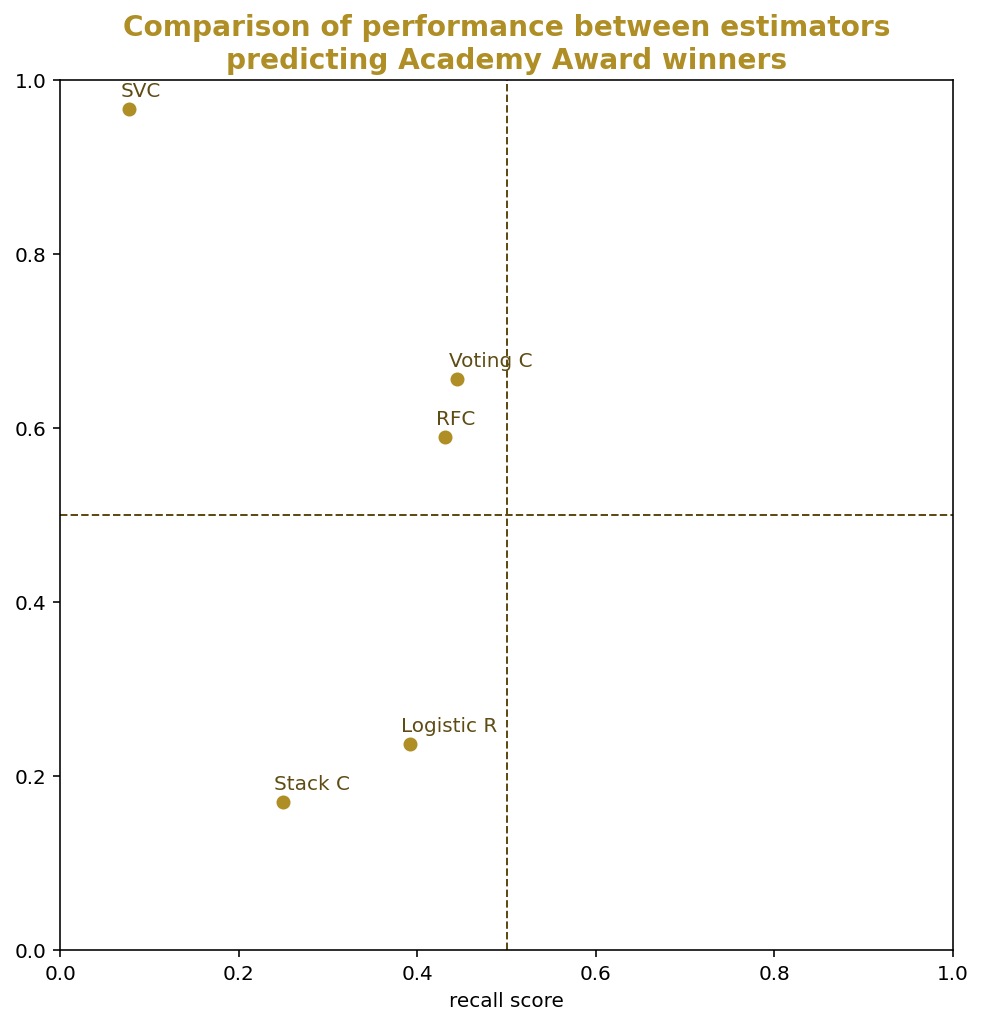

In [122]:
ests_win = [vote_win, stack_win, lr_win, svc_win, rfc_win]
ests_win_labels = ['Voting C', 'Stack C', 'Logistic R', 'SVC', 'RFC']
prec_win = [0.445, 0.25, 0.3917, 0.0773, 0.4315]
rec_win = [0.6561, 0.1697, 0.2364, 0.9667, 0.5894]
plt.figure(figsize = (8,8))
plt.title('Comparison of performance between estimators\npredicting Academy Award winners', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#ae8e25'})
plt.scatter(prec_win, rec_win, c = '#ae8e25')
plt.xlim(0,1)
plt.xlabel('precision score')
plt.ylim(0,1)
plt.xlabel('recall score')
plt.axhline(0.5, ls = '--', lw = 1, c = '#5e4c14')
plt.axvline(0.5, ls = '--', lw = 1, c = '#5e4c14')
for i in range(len(ests_win)):
    plt.text(prec_win[i]-0.01, rec_win[i]+0.015, ests_win_labels[i], c = '#5e4c14')

***

## PART 3: Predicting which movie might **get nominated** for Best Picture

### 3.1. Baseline model

In [73]:
movies['best_pic'].value_counts(normalize= False)

0    175467
1       228
Name: best_pic, dtype: int64

In [74]:
y = movies['best_pic']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9987 and recall of 0.0.


### 3.2. Bootstrapping and scaling the training data

In [75]:
movies_train_btstrp = pd.concat([movies_train, movies_train[movies_train['best_pic']==1].sample(n = 100000, replace = True, random_state=113)], axis = 0) # randomly resampling additional 100,000 titles with Oscar nominations or wins into the training set
movies_train_btstrp['best_pic'].value_counts(normalize=False)

0    131600
1    100171
Name: best_pic, dtype: int64

In [76]:
y_train = movies_train_btstrp['best_pic']
X_train = movies_train_btstrp[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['best_pic']

stan_bp = StandardScaler()
Z_train = stan_bp.fit_transform(X_train)
Z_test = stan_bp.transform(X_test)

In [127]:
pickle.dump(stan_bp, open('../pickles/stan_bp.p', 'wb')) #saving the scaler to apply to 2020 data for 2021 Oscars predictions

### 3.3. Logistic regression on bootstrapped data

#### 3.3.1. Predicting best picture contenders using all independent variabless in `X-vars_all`

In [77]:
lr_bp = LogisticRegression(max_iter = 10000)
lr_bp.fit(Z_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(lr_bp.score(Z_train, y_train),4)} on train data and {round(lr_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, lr_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, lr_bp.predict(Z_test)),4)} on test data.")
print(f"The model has a precision score of {round(precision_score(y_train, lr_bp.predict(Z_train)),4)} on train data and {round(precision_score(y_test, lr_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp, Z_test, y_test, scoring='precision').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.4998 on train data and 0.1277 on test data.
The same model has a recall score of 0.9882 on train data and 0.9825 on test data.
The model has a precision score of 0.4631 on train data and 0.0015 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9984.
The model's recall calculated in 5-fold cross-validation is 0.2985.
The model's precision calculated in 5-fold cross-validation is 0.3538.


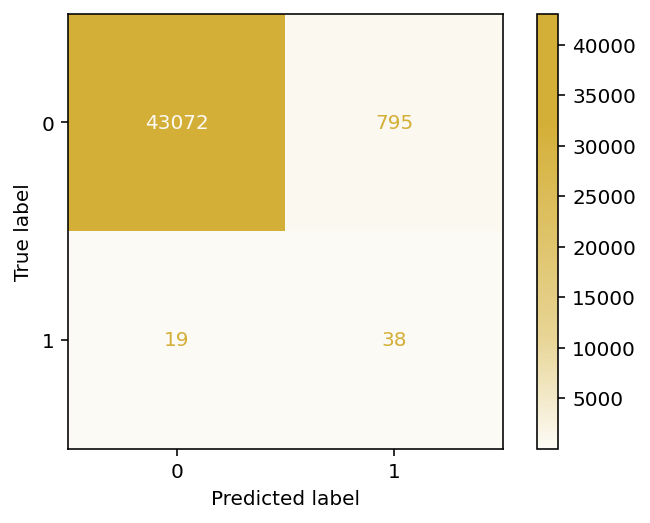

In [78]:
plot_confusion_matrix(lr_bp, Z_test, y_test, cmap = golds_cm);

### 3.4. Random Forest Classification on bootstrapped data

#### 3.4.1 Predicting Best Picture contenders using all independent variabless in X-vars_all

In [79]:
pd.options.mode.chained_assignment = None  # default='warn'

In [60]:
#rfc_bp = pickle.load(open('../pickles/rfc_bp.p', 'rb'))

In [80]:
rfc_bp = RandomForestClassifier(max_depth= 20, min_samples_leaf= 3,class_weight= {0: 0.01, 1: 0.99})
rfc_bp.fit(Z_train, y_train)

print(f"The Random Forest Classifier has an accuracy of {round(rfc_bp.score(Z_train, y_train),4)} on train data and {round(rfc_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, rfc_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, rfc_bp.predict(Z_test)),4)} on test data.")
print(f"The model's has a precision score is {round(precision_score(y_train, rfc_bp.predict(Z_train)),4)} on train data and {round(precision_score(y_test, rfc_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp, Z_test, y_test, scoring='precision').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9988 on train data and 0.9969 on test data.
The same model has a recall score of 1.0 on train data and 0.7719 on test data.
The model's has a precision score is 0.9972 on train data and 0.2651 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9984.
The model's recall calculated in 5-fold cross-validation is 0.647.
The model's precision calculated in 5-fold cross-validation is 0.4461.


In [81]:
pickle.dump(rfc_bp, open('../pickles/rfc_bp.p', 'wb'))

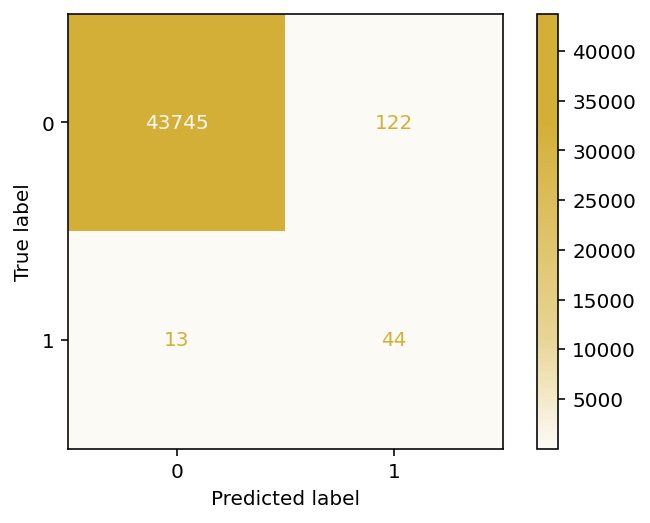

In [82]:
plot_confusion_matrix(rfc_bp, Z_test, y_test, cmap = golds_cm)
plt.savefig('../visualizations/cm_rfc_bp.png',facecolor=fig1.get_facecolor(), edgecolor='none')

#### 3.4.2 Viewing and interpreting coefficients for most predictive variables

In [83]:
perm_imp = permutation_importance(rfc_bp, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X_train.columns, columns = ['permutation_imp'])

rfc_bp_features = pd.DataFrame(index = X_train.columns, data = rfc_bp.feature_importances_, columns=['feature_importance'])
rfc_bp_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_bp_features = rfc_bp_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_bp_features[:10]

,feature_importance,permutation_imp
budget_USD,0.243836,-0.001557
runtimeMinutes,0.148628,-0.001143
prev_Oscars,0.131990,-0.001493
US_open_WE,0.086027,-0.000337
GG,0.068700,-0.000938
Documentary,0.061285,-0.000455
rel_USA,0.042490,-0.001266
Drama,0.041924,-0.000647
prev_Oscar_noms_nm,0.029512,-0.000897
prev_Oscar_wins_nm,0.022822,-0.000332


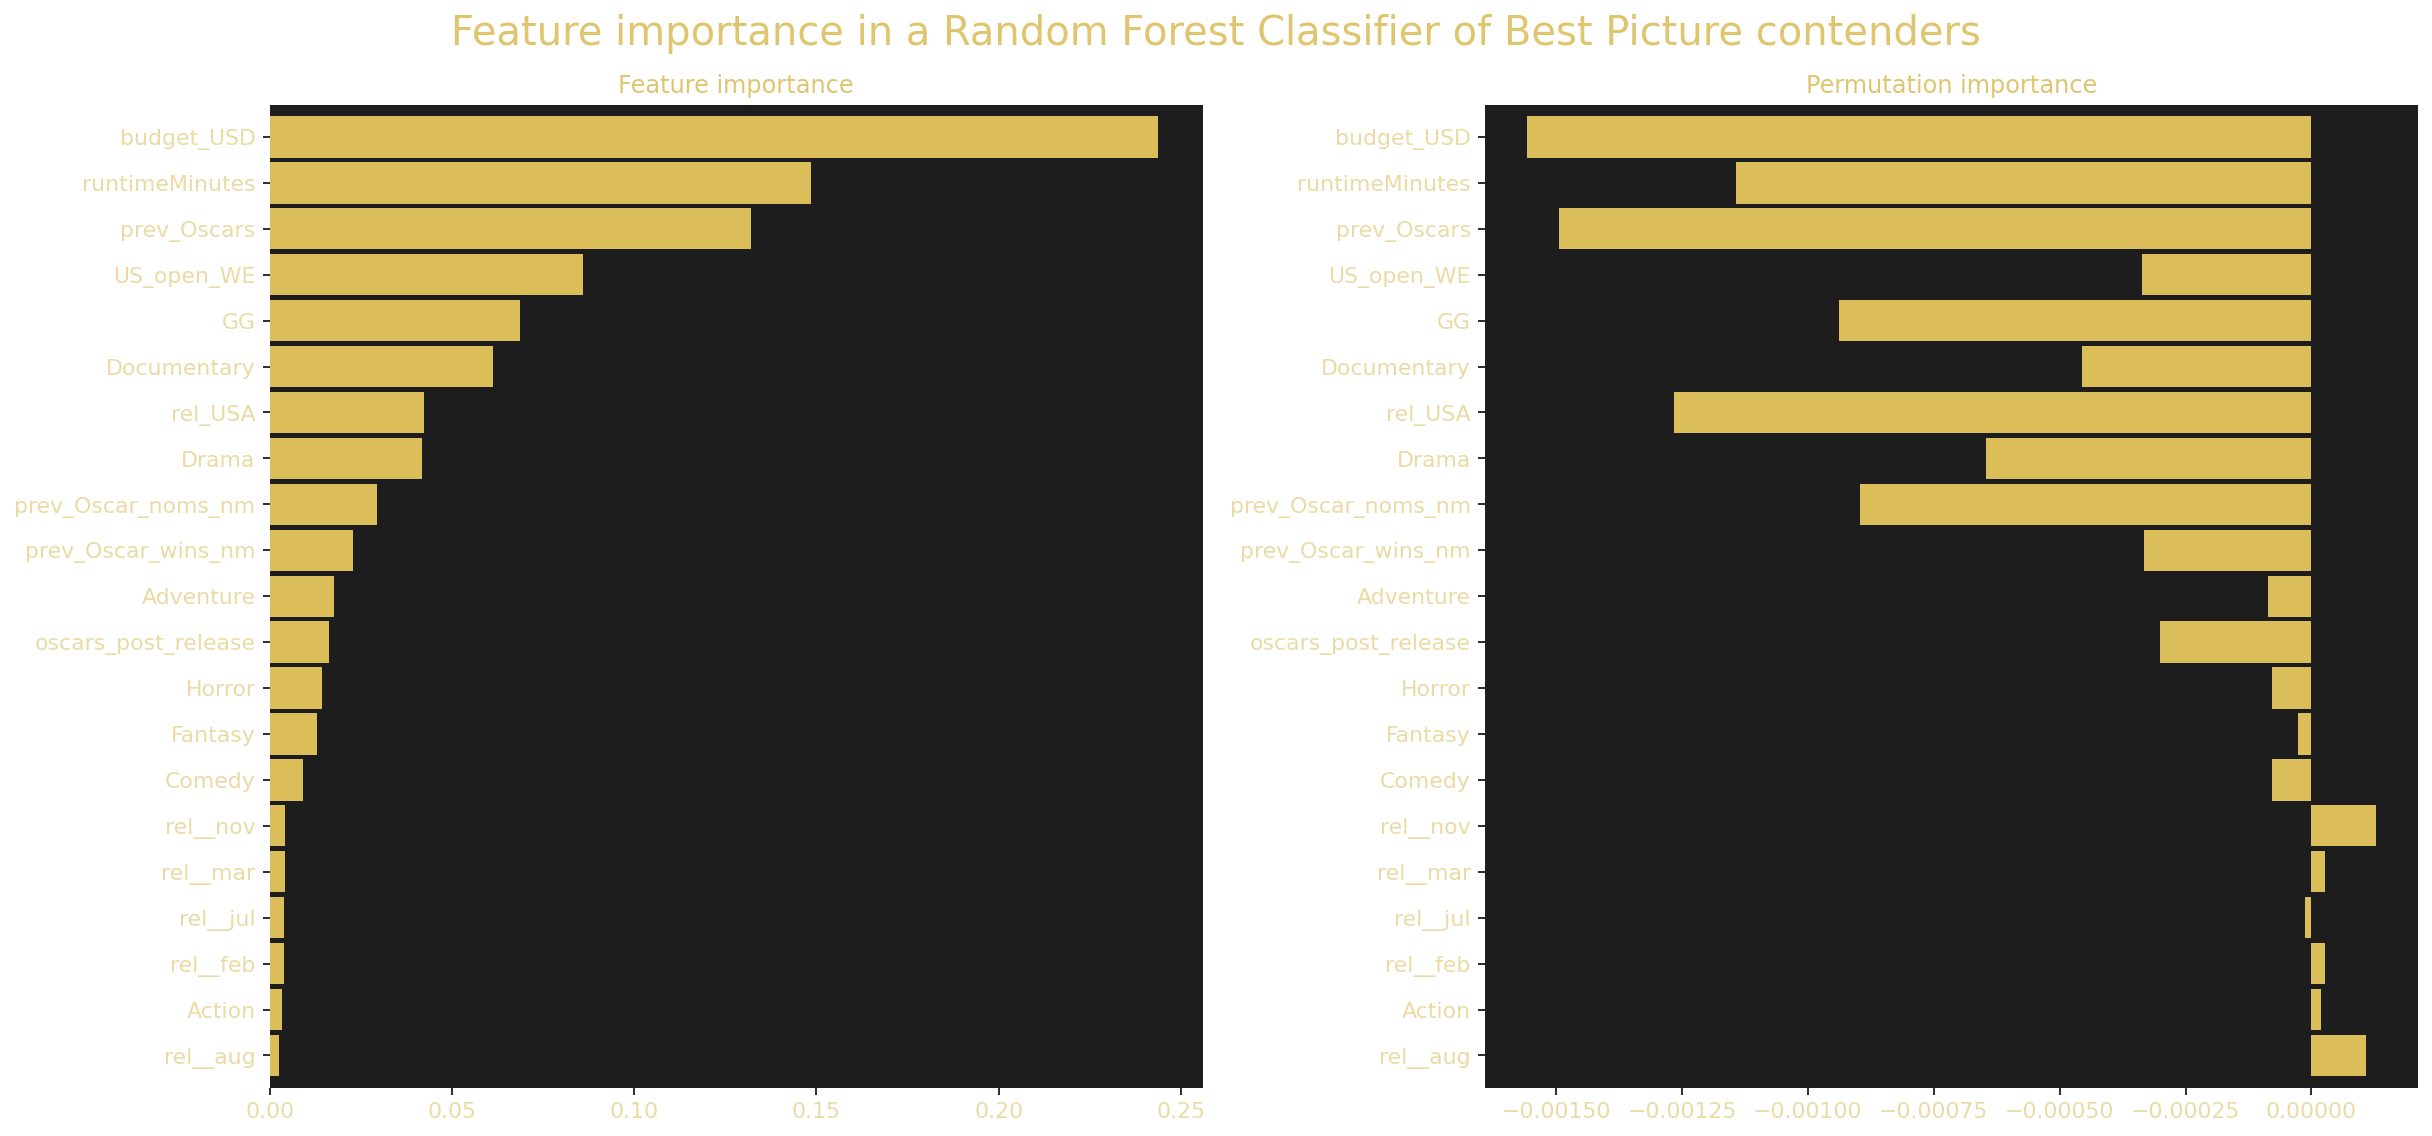

In [112]:
plt.figure(figsize=(17,8));
plt.suptitle('Feature importance in a Random Forest Classifier of Best Picture contenders', fontsize = 20);
plt.subplot(1,2,1);
fig1 = rfc_bp_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9);
fig1.patch.set_facecolor('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.subplot(1,2,2);
fig2 = rfc_bp_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
fig2.patch.set_facecolor('#1d1d1d')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_bp.png',facecolor=fig1.get_facecolor(), edgecolor='none')

### 3.5. FFNN

In [65]:
movies['best_pic'] = movies['picture_NW'].notna().astype(int)

movies_train, movies_test = train_test_split(movies, random_state = 113, stratify = movies['best_pic'])

y_train = movies_train['best_pic']
X_train = movies_train[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['best_pic']

#stan = StandardScaler()
stan = pickle.load( open('../pickles/stan_bp.p', 'rb'))
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [47]:
#pickle.dump(stan, open('../pickles/stan_bp.p', 'wb'))

In [48]:
def build_nn(train_features, hid_activation, dropout_rate, learn_rate, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    nn = Sequential()
    nn.add(layers.InputLayer(input_shape = (train_features.shape[1],)))
    nn.add(layers.Dense(512, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(512, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(256, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(256, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(64, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(64, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(32, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(16, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias))
    nn.compile(optimizer = Adam(learning_rate = learn_rate), loss = 'binary_crossentropy', metrics = ['AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return nn

In [49]:
initial_bias = np.log([y_train.sum()/len(y_train)])

In [54]:
nn_bp = build_nn(Z_train, 'relu', 0.2, 0.001, output_bias = initial_bias)
nn_bp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               32768     
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)               

In [55]:
zero_wght = len(y_train)/(2*len(y_train[y_train == 0]))
one_wght = len(y_train)/(2*len(y_train[y_train == 1]))

In [56]:
es = EarlyStopping(monitor = 'val_auc', patience = 10, mode = 'max', restore_best_weights = True)

In [57]:
history = nn_bp.fit(Z_train, y_train, validation_data=(Z_test, y_test), callbacks = es, epochs = 100, class_weight={0: zero_wght, 1: one_wght}, workers = 3)

Epoch 1/100
4118/4118 [==============================] - 18s 4ms/step - loss: 4.3478 - auc: 0.7688 - true_positives: 48.5290 - true_negatives: 64712.7361 - false_positives: 1120.7227 - false_negatives: 38.0019 - val_loss: 0.1794 - val_auc: 0.9962 - val_true_positives: 54.0000 - val_true_negatives: 43458.0000 - val_false_positives: 409.0000 - val_false_negatives: 3.0000
Epoch 2/100
4118/4118 [==============================] - 16s 4ms/step - loss: 1.3798 - auc: 0.8980 - true_positives: 70.2207 - true_negatives: 64211.7783 - false_positives: 1621.5004 - false_negatives: 16.4904 - val_loss: 0.4280 - val_auc: 0.9938 - val_true_positives: 57.0000 - val_true_negatives: 43081.0000 - val_false_positives: 786.0000 - val_false_negatives: 0.0000e+00tives: 58574.8164 - fal
Epoch 3/100
4118/4118 [==============================] - 18s 4ms/step - loss: 1.2005 - auc: 0.9077 - true_positives: 62.3372 - true_negatives: 64751.3008 - false_positives: 1078.7961 - false_negatives: 27.5557 - val_loss: 0.1321 

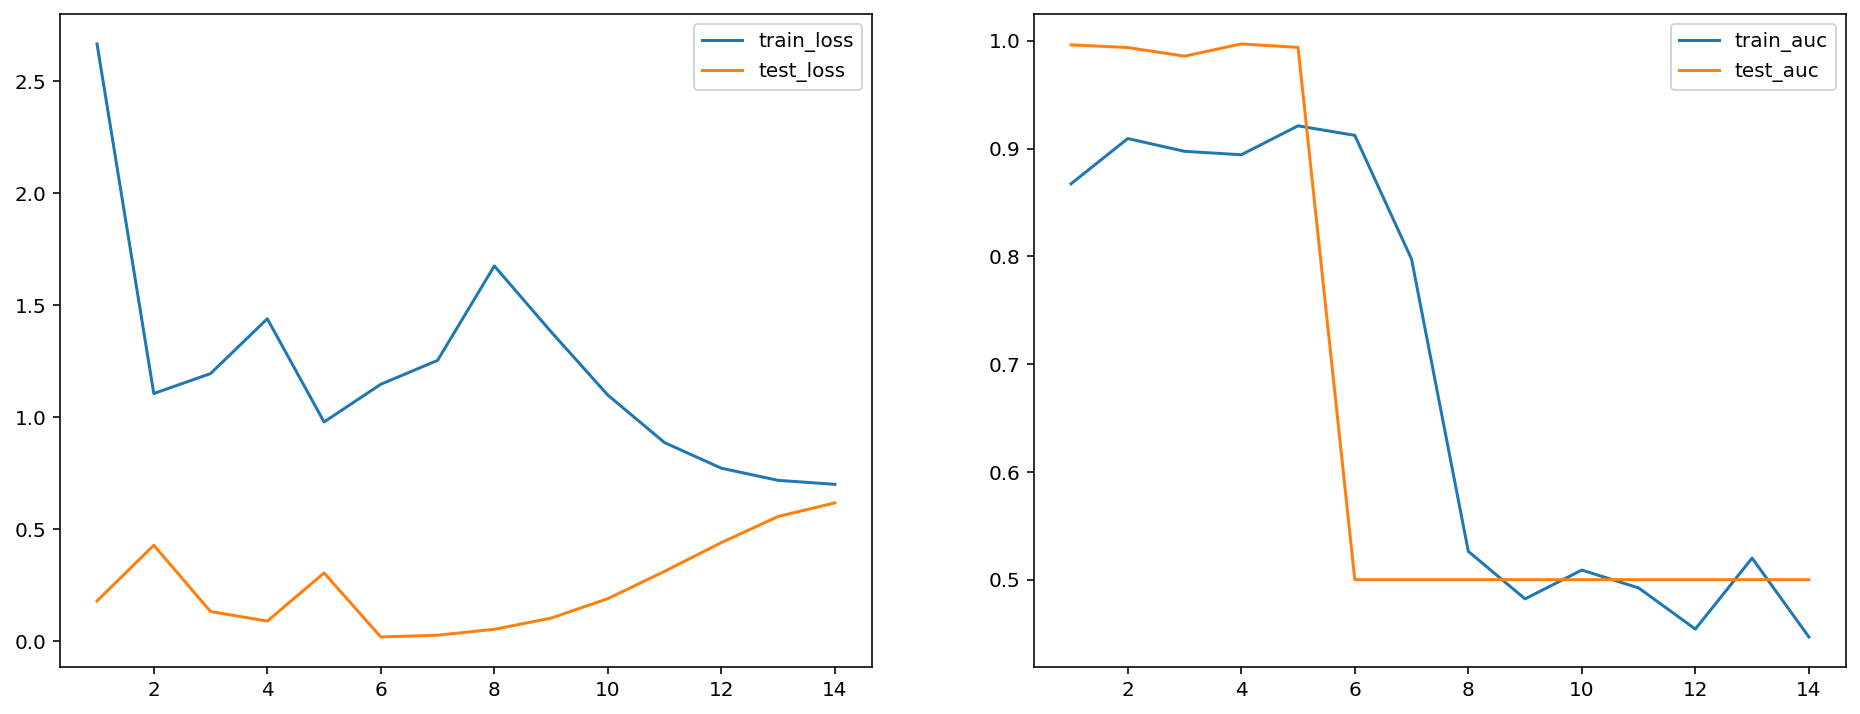

In [58]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label = 'test_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['auc'])+1), history.history['auc'], label = 'train_auc')
plt.plot(range(1, len(history.history['auc'])+1), history.history['val_auc'], label = 'test_auc')
plt.legend();

In [68]:
p = 0.5

test_acc = Accuracy()
test_acc.update_state(y_test, (nn_bp.predict(Z_test)>= p).astype(int))
train_acc = Accuracy()
train_acc.update_state(y_train, (nn_bp.predict(Z_train)>= p).astype(int))

test_rec = Recall()
test_rec.update_state(y_test, (nn_bp.predict(Z_test)>=p).astype(int))
train_rec = Recall()
train_rec.update_state(y_train, (nn_bp.predict(Z_train)>=p).astype(int))

test_prec = Precision()
test_prec.update_state(y_test, (nn_bp.predict(Z_test)>=p).astype(int))
train_prec = Precision()
train_prec.update_state(y_train, (nn_bp.predict(Z_train)>=p).astype(int))

#nn_nom.predict(Z_test, batch_size= len(y_test)).astype(int)).result().numpy()

In [69]:
print(f"The Neural Network Classifier has an accuracy of {round((train_acc.result().numpy()),4)} on train data and {round((test_acc.result().numpy()),4)} on test data.")
print(f"The same model has a recall score of {round(train_rec.result().numpy(),4)} on train data and {round(test_rec.result().numpy(),4)} on test data.")
print(f"The model has a precision score of {round(train_prec.result().numpy(),4)} on train data and {round(test_prec.result().numpy(),4)} on test data.")

#print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring = 'Accuracy').mean(),4)}.")
#print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Recall').mean(),4)}.")
#print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Precision').mean(),4)}.")

The Neural Network Classifier has an accuracy of 0.9922000169754028 on train data and 0.9923999905586243 on test data.
The same model has a recall score of 0.9825000166893005 on train data and 0.9473999738693237 on test data.
The model has a precision score of 0.1404999941587448 on train data and 0.13989999890327454 on test data.


In [65]:
#nn_bp.save('../models/nn_bp.h5')

In [67]:
nn_bp = tf.keras.models.load_model('../models/nn_bp.h5')

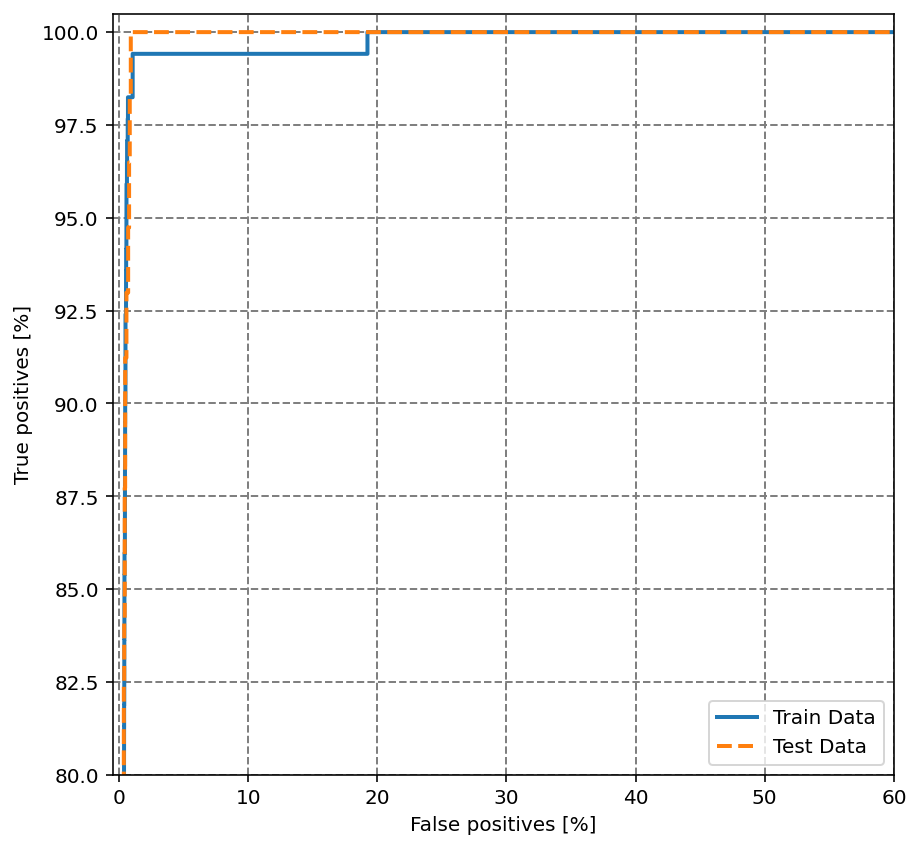

In [67]:
plt.figure(figsize = (7,7))
plot_roc("Train Data", y_train, nn_bp.predict(Z_train))
plot_roc("Test Data", y_test, nn_bp.predict(Z_test), linestyle='--')
plt.legend(loc='lower right');

Correctly identified as Not Best Picture Nominees (True Negatives):  130799
Incorectly identified as Best Picture Nominees (False Positives):  801
Incorectly identified as Not Best Picture Nominees (False Negatives):  6
Correctly identified as Best Picture Nominees (True Positives):  165
Total Nominees:  171


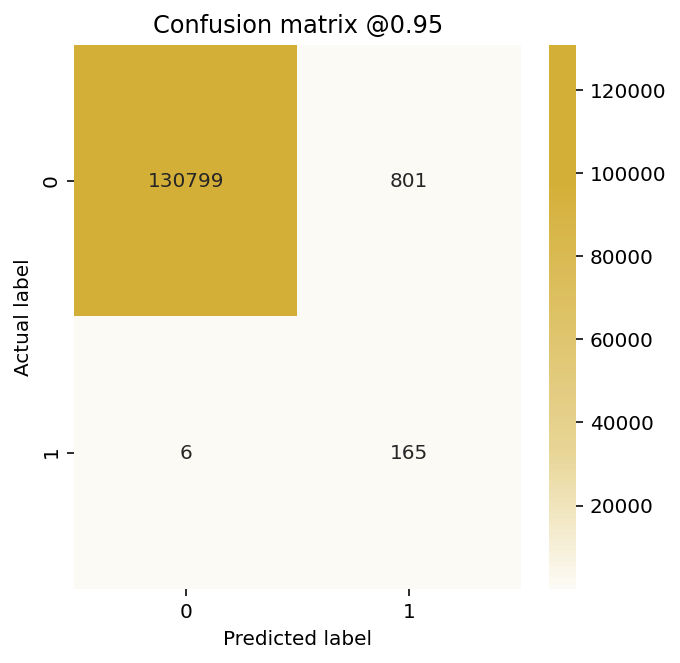

In [85]:
plot_cm(y_train, nn_bp.predict(Z_train), 0.95, 'Best Picture Nominees')

### 3.6. Support Vector Classifier on bootstrapped data

In [85]:
svc_bp = SVC(C = 0.5, class_weight = 'balanced')
svc_bp.fit(Z_train, y_train)

#svc_bp = pickle.load(open('../pickles/svc_bp.p', 'rb'))

print(f"The Support Vector Classifier has an accuracy of {round(svc_bp.score(Z_train, y_train),4)} on train data and {round(svc_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, svc_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, svc_bp.predict(Z_test)),4)} on test data.")
print(f"The model's has a precision score is {round(precision_score(y_train, svc_bp.predict(Z_train)),4)} on train data and {round(precision_score(y_test, svc_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(svc_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(svc_bp, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(svc_bp, Z_test, y_test, scoring='precision').mean(),4)}.")


The Support Vector Classifier has an accuracy of 0.9988 on train data and 0.9968 on test data.
The same model has a recall score of 1.0 on train data and 0.5614 on test data.
The model's has a precision score is 0.9973 on train data and 0.2192 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.998.
The model's recall calculated in 5-fold cross-validation is 0.1591.
The model's precision calculated in 5-fold cross-validation is 0.149.


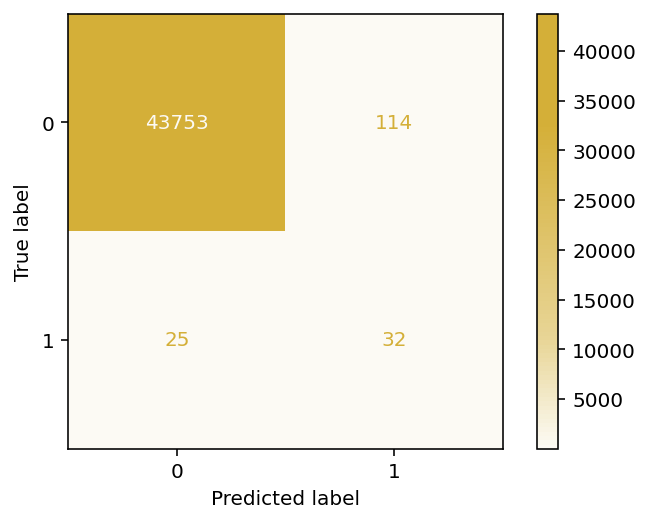

In [86]:
plot_confusion_matrix(svc_bp, Z_test, y_test, cmap = golds_cm);
#plt.savefig('../visualizations/cm_svc_nom.png',facecolor=fig.get_facecolor(), edgecolor='none')

### 3.7. Voting Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [87]:
vote_bp = VotingClassifier(estimators=[('rf', rfc_bp), ('sv', svc_bp), ('lr', lr_bp)])
vote_bp.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(vote_bp.score(Z_train, y_train),4)} on train data and {round(vote_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, vote_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, vote_bp.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, vote_bp.predict(Z_train)),4)} on train data and {round(precision_score(y_test, vote_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp, Z_test, y_test, scoring='precision').mean(),4)}.")

The Voting Classifier has an accuracy of 0.9984 on train data and 0.9962 on test data.
The same model has a recall score of 1.0 on train data and 0.8596 on test data.
The same model has a precision score of 0.9962 on train data and 0.2367 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9985.
The model's recall calculated in 5-fold cross-validation is 0.3152.
The model's precision calculated in 5-fold cross-validation is 0.3804.


In [88]:
pickle.dump(vote_bp, open('../pickles/vote_bp.p', 'wb'))

### 3.8. Stacking Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [89]:
stack_bp = StackingClassifier(estimators=[('rf', rfc_bp), ('sv', svc_bp), ('lr', lr_bp)])
stack_bp.fit(Z_train, y_train)

print(f"The Stacking Classifier has an accuracy of {round(stack_bp.score(Z_train, y_train),4)} on train data and {round(stack_bp.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, stack_bp.predict(Z_train)),4)} on train data and {round(recall_score(y_test, stack_bp.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, stack_bp.predict(Z_train)),4)} on train data and {round(precision_score(y_test, stack_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp, Z_test, y_test, scoring='precision').mean(),4)}.")

The Stacking Classifier has an accuracy of 0.9998 on train data and 0.9985 on test data.
The same model has a recall score of 1.0 on train data and 0.3158 on test data.
The same model has a precision score of 0.9994 on train data and 0.3913 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9986.
The model's recall calculated in 5-fold cross-validation is 0.2636.
The model's precision calculated in 5-fold cross-validation is 0.374.


In [90]:
pickle.dump(stack_bp, open('../pickles/stack_bp.p', 'wb'))

### 3.9. Picking the best prediction algorightm based on precision and recall

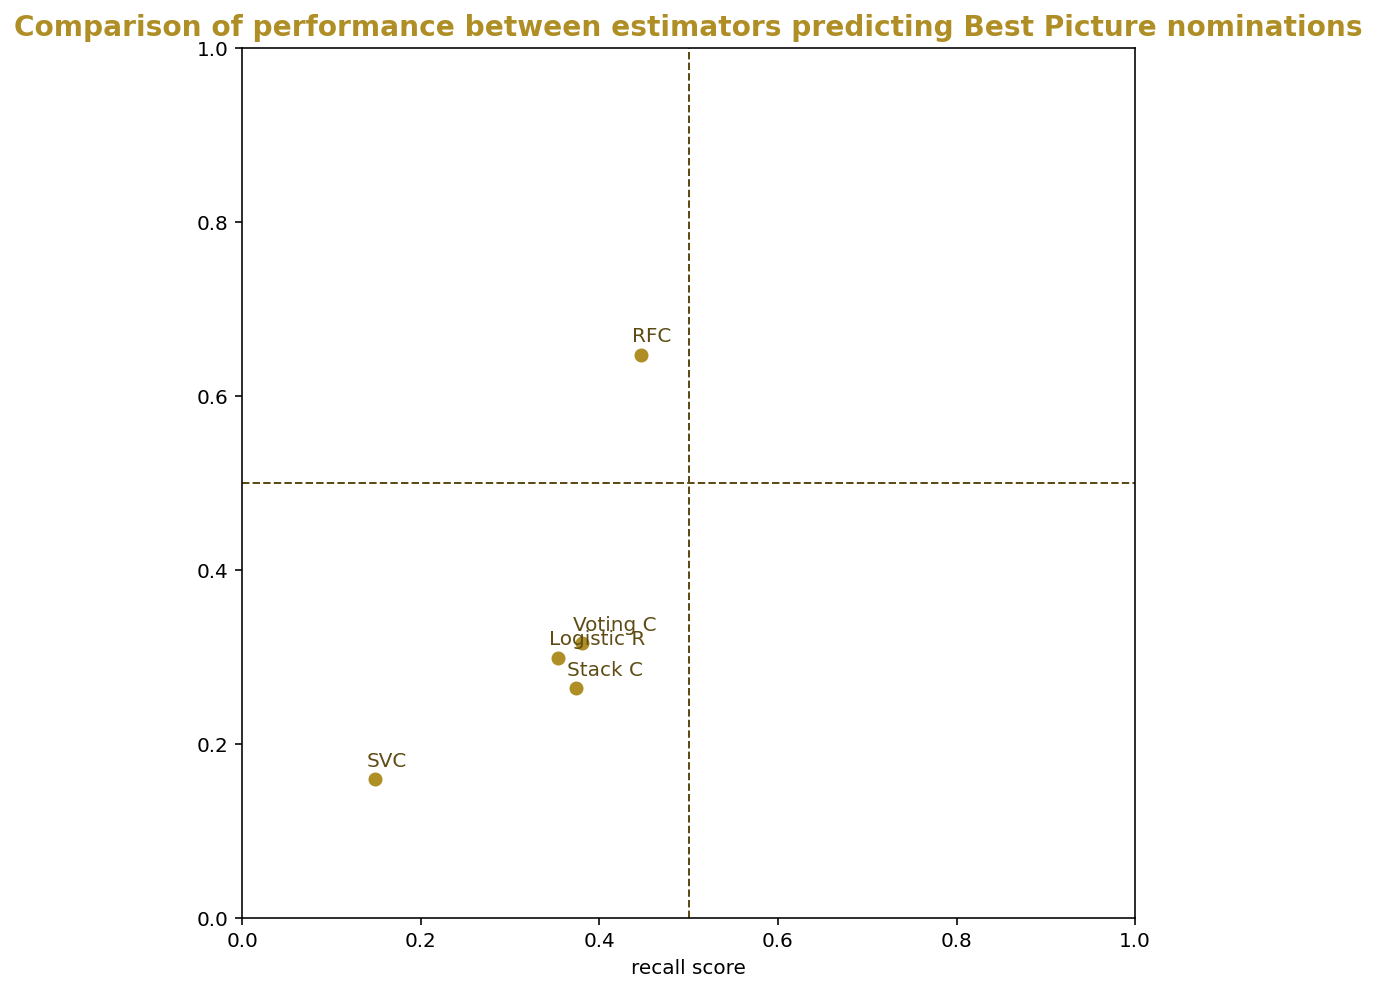

In [124]:
ests_bp_nom = [vote_bp, stack_bp, lr_bp, svc_bp, rfc_bp]
ests_bp_nom_labels = ['Voting C', 'Stack C', 'Logistic R', 'SVC', 'RFC']
prec_bp_nom = [0.3804, 0.374, 0.3538, 0.149, 0.4461]
rec_bp_nom = [0.3152, 0.2636, 0.2985, 0.1591, 0.647]

plt.figure(figsize = (8,8))
plt.title('Comparison of performance between estimators predicting Best Picture nominations', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#ae8e25'})
plt.scatter(prec_bp_nom, rec_bp_nom, c = '#ae8e25')
plt.xlim(0,1)
plt.xlabel('precision score')
plt.ylim(0,1)
plt.xlabel('recall score')
plt.axhline(0.5, ls = '--', lw = 1, c = '#5e4c14')
plt.axvline(0.5, ls = '--', lw = 1, c = '#5e4c14')
for i in range(len(ests_bp_nom)):
    plt.text(prec_bp_nom[i]-0.01, rec_bp_nom[i]+0.015, ests_bp_nom_labels[i], c = '#5e4c14')

***

## PART 4: Predicting which movies have the highest chances of **winning** Best Picture

### 4.1. Baseline model

In [91]:
movies['best_pic_win'].value_counts(normalize= False)

0    175665
1        30
Name: best_pic_win, dtype: int64

In [92]:
y = movies['best_pic_win']
bm = BaselineModel(y)
print(f"The naive baseline model has accuracy of {round(bm.score(),4)} and recall of {round(recall_score(y, bm.predict()),4)}.")

The naive baseline model has accuracy of 0.9998 and recall of 0.0.


### 4.2. Bootstrapping and scaling the training data

In [93]:
movies_train_btstrp = pd.concat([movies_train, movies_train[movies_train['best_pic_win']==1].sample(n = 100000, replace = True, random_state=113)], axis = 0) # randomly resampling additional 100,000 titles with Oscar nominations or wins into the training set
movies_train_btstrp['best_pic_win'].value_counts(normalize=False)

0    131748
1    100023
Name: best_pic_win, dtype: int64

In [129]:
y_train = movies_train_btstrp['best_pic_win']
X_train = movies_train_btstrp[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['best_pic_win']

stan_bp_win = StandardScaler()
pickle.dump(stan_bp_win, open('../pickles/stan_bp_win.p', 'wb')) #saving the scaler to apply to 2020 data for 2021 Oscars predictions
Z_train = stan_bp_win.fit_transform(X_train)
Z_test = stan_bp_win.transform(X_test)

### 4.3. Logistic regression on bootstrapped data

#### 4.3.1. Predicting best picture winners using all independent variabless in `X-vars_all`

In [130]:
lr_bp_win = LogisticRegression()
lr_bp_win.fit(Z_train, y_train)

print(f"Logistic regression using five most predictive variables has accuracy of {round(lr_bp_win.score(Z_train, y_train),4)} on train data and {round(lr_bp_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, lr_bp_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, lr_bp_win.predict(Z_test)),4)} on test data.")
print(f"The model's has a precision score is {round(precision_score(y_train, lr_bp_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, lr_bp.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(lr_bp_win, Z_test, y_test, scoring='precision').mean(),4)}.")

Logistic regression using five most predictive variables has accuracy of 0.9993 on train data and 0.9983 on test data.
The same model has a recall score of 1.0 on train data and 0.2857 on test data.
The model's has a precision score is 0.9985 on train data and 0.0059 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9998.
The model's recall calculated in 5-fold cross-validation is 0.2.
The model's precision calculated in 5-fold cross-validation is 0.2.


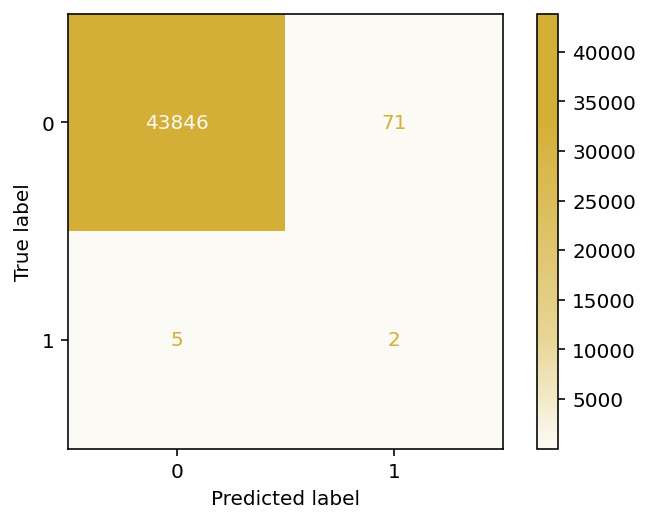

In [131]:
plot_confusion_matrix(lr_bp_win, Z_test, y_test, cmap = golds_cm);

### 4.4. Random Forest Classification on bootstrapped data

#### 4.4.1 Predicting Best Picture winners using all independent variabless in X-vars_all

In [132]:
rfc_bp_win = RandomForestClassifier(class_weight={0:0.001, 1: 0.999}, max_depth=15, min_samples_leaf=5, max_features=15, bootstrap=False)
rfc_bp_win.fit(Z_train, y_train)

#rfc_bp_win = pickle.load(open('../pickles/rfc_bp_win.p', 'rb'))

print(f"The Random Forest Classifier has an accuracy of {round(rfc_bp_win.score(Z_train, y_train),4)} on train data and {round(rfc_bp_win.score(Z_test, y_test),4)} on test data.")
print(f"The same mode has a recall score of {round(cross_val_score(rfc_bp_win, Z_train, y_train, scoring='recall').mean(),4)} on train data and {round(cross_val_score(rfc_bp_win, Z_test, y_test, scoring='recall').mean(),4)} on test data.")
print(f"The model's precision score is {round(cross_val_score(rfc_bp_win, Z_train, y_train, scoring='precision').mean(),4)} on train data {round(cross_val_score(rfc_bp_win, Z_test, y_test, scoring='precision').mean(),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.")
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(rfc_bp_win, Z_test, y_test, scoring='precision').mean(),4)}.")

The Random Forest Classifier has an accuracy of 0.9989 on train data and 0.9979 on test data.
The same mode has a recall score of 1.0 on train data and 0.2 on test data.
The model's precision score is 0.9974 on train data 0.1 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9998.
The model's recall calculated in 5-fold cross-validation is 0.2.
The model's precision calculated in 5-fold cross-validation is 0.0667.


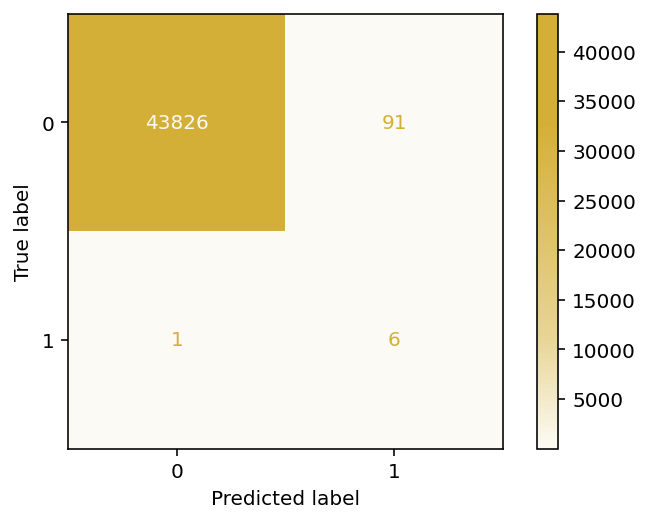

In [133]:
plot_confusion_matrix(rfc_bp_win, Z_test, y_test, cmap = golds_cm);

In [134]:
pickle.dump(rfc_bp_win, open('../pickles/rfc_bp_win.p', 'wb'))

#### 4.4.2 Viewing and interpreting coefficients for most predictive variables

In [135]:
perm_imp = permutation_importance(rfc_bp_win, Z_test, y_test)['importances_mean']

perm_imp_df = pd.DataFrame(perm_imp, index =X_train.columns, columns = ['permutation_imp'])

rfc_bp_win_features = pd.DataFrame(index = X_train.columns, data = rfc_bp_win.feature_importances_, columns=['feature_importance'])
rfc_bp_win_features.sort_values(['feature_importance'], ascending = False, inplace = True)
rfc_bp_win_features = rfc_bp_win_features.merge(perm_imp_df, left_index = True, right_index = True)

rfc_bp_win_features[:10]

,feature_importance,permutation_imp
GG,0.379668,-0.001885
budget_USD,0.279676,-0.001862
rel_USA,0.138254,-0.001266
runtimeMinutes,0.138088,-0.001239
Documentary,0.031574,-0.000036
Horror,0.010589,-0.000023
rel__sep,0.005745,-0.000046
rel__mar,0.005408,-0.000082
rel__jun,0.002622,-0.000059
US_open_WE,0.002566,0.000250


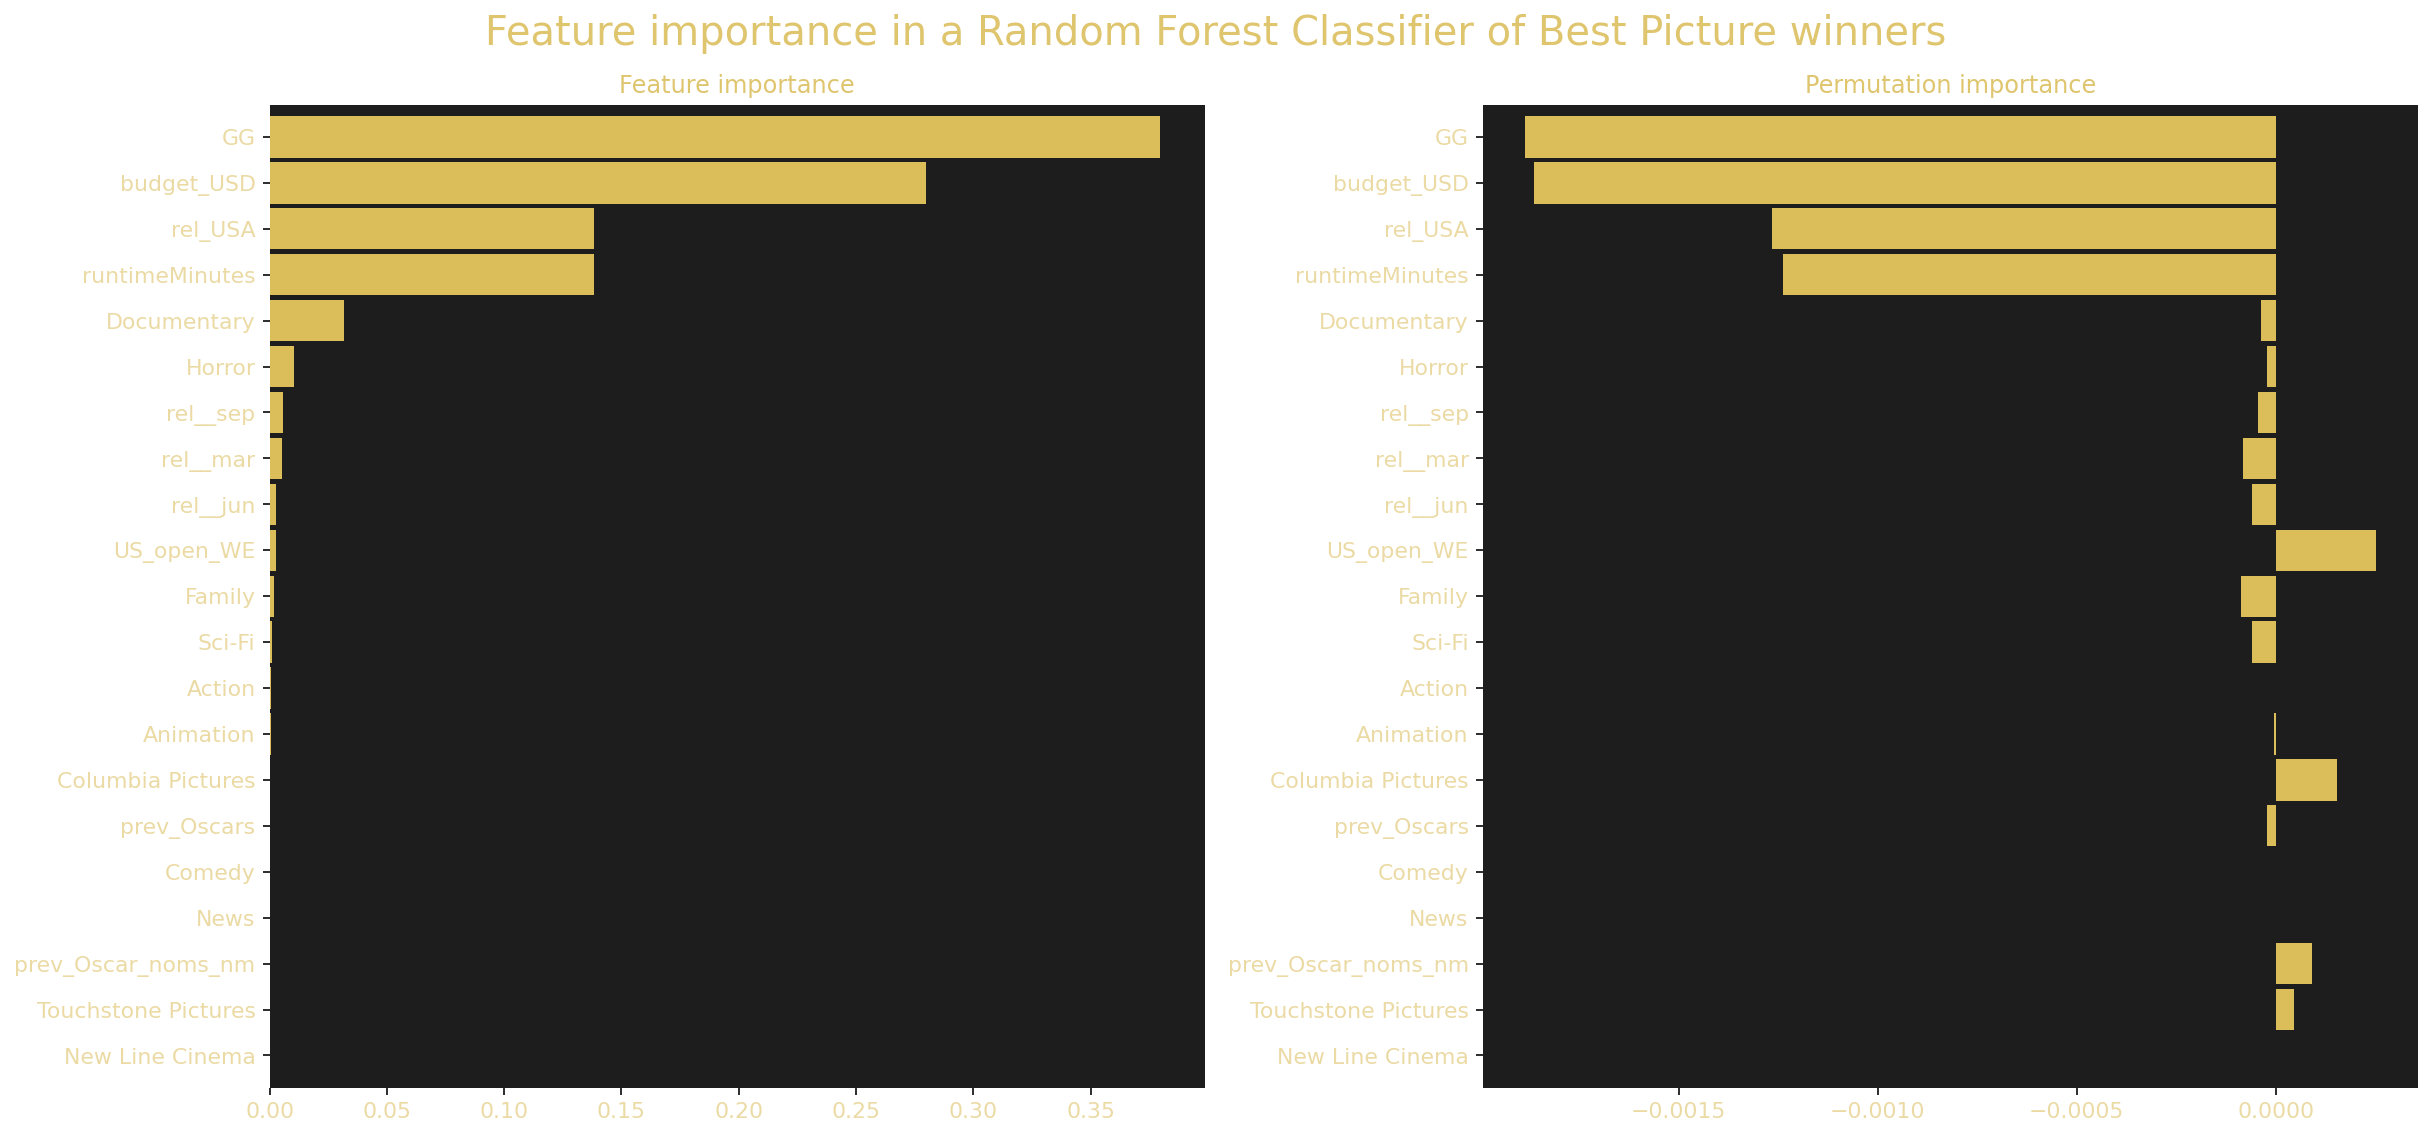

In [136]:
plt.figure(figsize=(17,8));
plt.suptitle('Feature importance in a Random Forest Classifier of Best Picture winners', fontsize = 20);
plt.subplot(1,2,1);
fig1 = rfc_bp_win_features[20::-1]['feature_importance'].plot(kind= 'barh', cmap = golds, title = '\n\nFeature importance', width = 0.9);
fig1.patch.set_color('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.subplot(1,2,2);
fig2 = rfc_bp_win_features[20::-1]['permutation_imp'].plot(kind= 'barh', cmap = golds, title = 'Permutation importance', width = 0.9);
fig2.patch.set_color('#1d1d1d')
plt.yticks(fontsize=11, color='#ebdaa4')
plt.xticks(fontsize=11, color='#ebdaa4')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.tight_layout();

plt.savefig('../visualizations/feat_imp_rfc_bp_win.png',facecolor=fig1.get_facecolor(), edgecolor='none')

### 4.5. FFNN

#### 4.5.1 Predicting Best Picture winners using all independent variabless in X-vars_all

In [137]:
movies['best_pic_win'] = (movies['picture_NW']=='W').astype(int)

movies_train, movies_test = train_test_split(movies, random_state = 113, stratify = movies['best_pic_win'])

y_train = movies_train['best_pic_win']
X_train = movies_train[X_vars_all]
X_test = movies_test[X_vars_all]
y_test = movies_test['best_pic_win']

stan = StandardScaler()
stan = pickle.load( open('../pickles/stan_bp_win.p', 'rb'))
Z_train = stan.fit_transform(X_train)
Z_test = stan.transform(X_test)

In [138]:
#pickle.dump(stan, open('../pickles/stan_bp_win.p', 'wb'))

In [142]:
def build_nn(train_features, hid_activation, dropout_rate, learn_rate, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    nn = Sequential()
    nn.add(layers.InputLayer(input_shape = (train_features.shape[1],)))
    nn.add(layers.Dense(512, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(512, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(256, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(256, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(64, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    #nn.add(layers.Dense(64, activation = hid_activation))
    #nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(32, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(16, activation = hid_activation))
    nn.add(layers.Dropout(dropout_rate))
    nn.add(layers.Dense(1, activation = 'sigmoid', bias_initializer = output_bias))
    nn.compile(optimizer = Adam(learning_rate = learn_rate), loss = 'binary_crossentropy', metrics = ['AUC', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])
    
    return nn

In [143]:
initial_bias = np.log([y_train.sum()/len(y_train)])

In [144]:
nn_bp_win = build_nn(Z_train, 'relu', 0.1, 0.001, output_bias = initial_bias)
nn_bp_win.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 512)               32768     
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)               

In [145]:
zero_wght = len(y_train)/(2*len(y_train[y_train == 0]))
one_wght = len(y_train)/(2*len(y_train[y_train == 1]))

In [146]:
es = EarlyStopping(monitor = 'val_auc', patience = 10, mode = 'max', restore_best_weights = True)

In [147]:
history = nn_bp_win.fit(Z_train, y_train, validation_data=(Z_test, y_test), callbacks = es, epochs = 100, class_weight={0: zero_wght, 1: one_wght}, workers = 3)

Epoch 1/100
4118/4118 [==============================] - 25s 6ms/step - loss: 14.6652 - auc: 0.5098 - true_positives: 0.6463 - true_negatives: 65892.0784 - false_positives: 17.1607 - false_negatives: 10.1044 - val_loss: 0.1521 - val_auc: 0.9340 - val_true_positives: 7.0000 - val_true_negatives: 43566.0000 - val_false_positives: 350.0000 - val_false_negatives: 1.0000
Epoch 2/100
4118/4118 [==============================] - 15s 4ms/step - loss: 4.8299 - auc: 0.7694 - true_positives: 6.9828 - true_negatives: 65648.7060 - false_positives: 257.7594 - false_negatives: 6.5416 - val_loss: 0.0563 - val_auc: 0.6859 - val_true_positives: 3.0000 - val_true_negatives: 43794.0000 - val_false_positives: 122.0000 - val_false_negatives: 5.0000
Epoch 3/100
4118/4118 [==============================] - 23s 6ms/step - loss: 28.7911 - auc: 0.7481 - true_positives: 6.4003 - true_negatives: 65490.7541 - false_positives: 416.7842 - false_negatives: 6.0512 - val_loss: 0.0162 - val_auc: 0.5000 - val_true_positiv

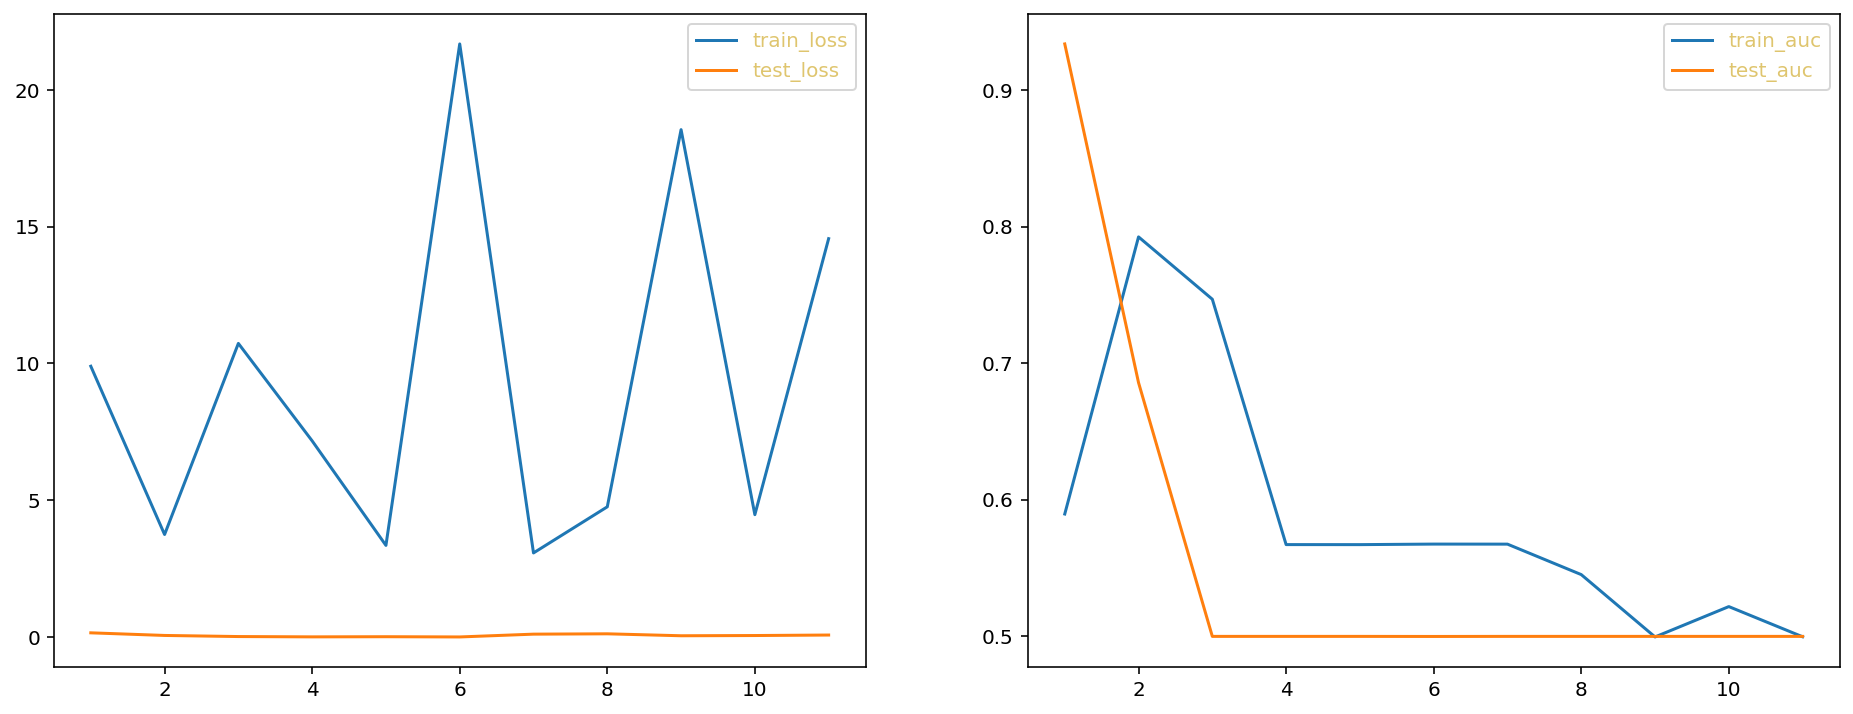

In [148]:
plt.figure(figsize = (16,6))
plt.subplot(1,2,1)
plt.plot(range(1, len(history.history['loss'])+1), history.history['loss'], label = 'train_loss')
plt.plot(range(1, len(history.history['loss'])+1), history.history['val_loss'], label = 'test_loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, len(history.history['auc'])+1), history.history['auc'], label = 'train_auc')
plt.plot(range(1, len(history.history['auc'])+1), history.history['val_auc'], label = 'test_auc')
plt.legend();

In [149]:
p = 0.5

test_acc = Accuracy()
test_acc.update_state(y_test, (nn_bp_win.predict(Z_test)>= p).astype(int))
train_acc = Accuracy()
train_acc.update_state(y_train, (nn_bp_win.predict(Z_train)>= p).astype(int))

test_rec = Recall()
test_rec.update_state(y_test, (nn_bp_win.predict(Z_test)>=p).astype(int))
train_rec = Recall()
train_rec.update_state(y_train, (nn_bp_win.predict(Z_train)>=p).astype(int))

test_prec = Precision()
test_prec.update_state(y_test, (nn_bp_win.predict(Z_test)>=p).astype(int))
train_prec = Precision()
train_prec.update_state(y_train, (nn_bp_win.predict(Z_train)>=p).astype(int))

#nn_nom.predict(Z_test, batch_size= len(y_test)).astype(int)).result().numpy()

In [150]:
print(f"The Neural Network Classifier has an accuracy of {round((train_acc.result().numpy()),4)} on train data and {round((test_acc.result().numpy()),4)} on test data.")
print(f"The same model has a recall score of {round(train_rec.result().numpy(),4)} on train data and {round(test_rec.result().numpy(),4)} on test data.")
print(f"The model has a precision score of {round(train_prec.result().numpy(),4)} on train data and {round(test_prec.result().numpy(),4)} on test data.")

#print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring = 'Accuracy').mean(),4)}.")
#print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Recall').mean(),4)}.")
#print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(nn_nom, Z_test, y_test, scoring='Precision').mean(),4)}.")

The Neural Network Classifier has an accuracy of 0.9915000200271606 on train data and 0.9919999837875366 on test data.
The same model has a recall score of 1.0 on train data and 0.875 on test data.
The model has a precision score of 0.019300000742077827 on train data and 0.019600000232458115 on test data.


In [151]:
#nn_bp_win.save('../models/nn_bp_win.h5')

In [152]:
nn_bp_win = tf.keras.models.load_model('../models/nn_bp_win.h5')

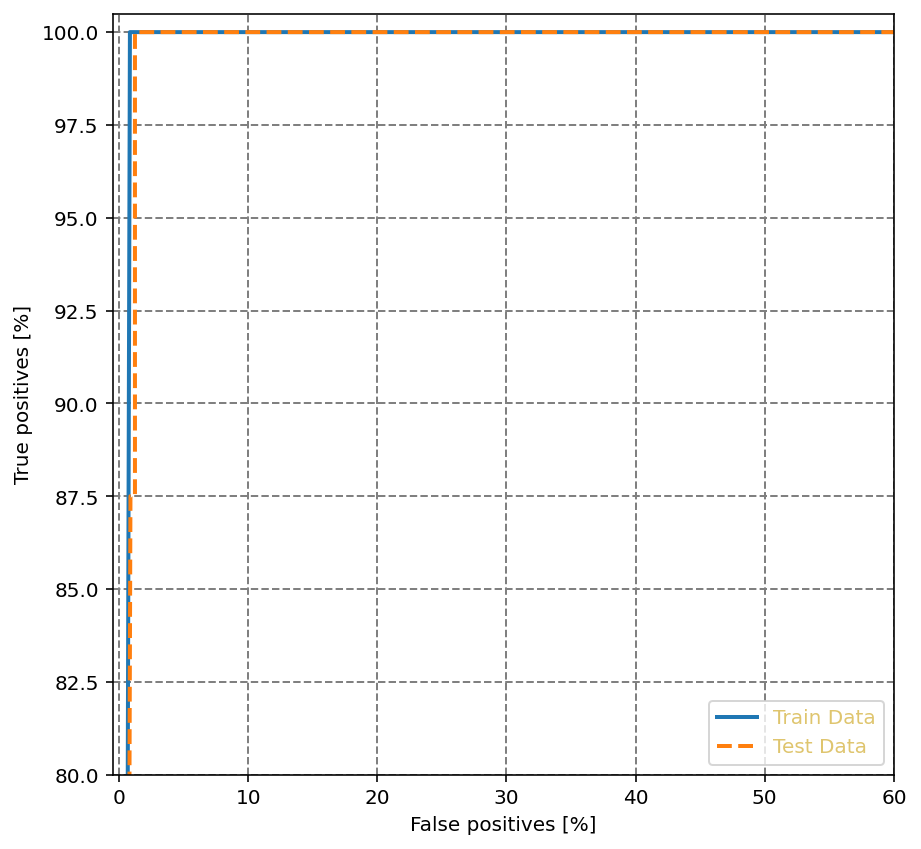

In [153]:
plt.figure(figsize = (7,7))
plot_roc("Train Data", y_train, nn_bp_win.predict(Z_train))
plot_roc("Test Data", y_test, nn_bp_win.predict(Z_test), linestyle='--')
plt.legend(loc='lower right');

Correctly identified as Not Best Picture Winners (True Negatives):  43530
Incorectly identified as Best Picture Winners (False Positives):  386
Incorectly identified as Not Best Picture Winners (False Negatives):  1
Correctly identified as Best Picture Winners (True Positives):  7
Total Nominees:  8


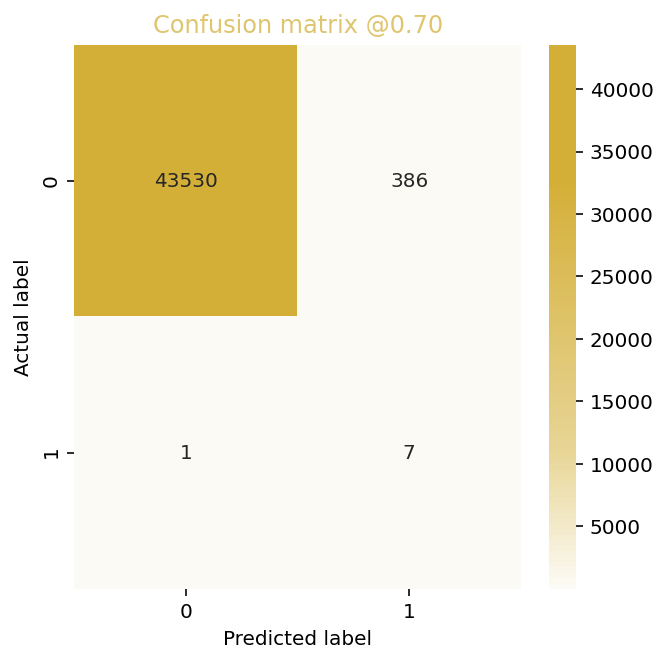

In [154]:
plot_cm(y_test, nn_bp_win.predict(Z_test), 0.7, 'Best Picture Winners')

### 4.6. Support Vector Classifier on bootstrapped data

In [155]:
svc_bp_win = SVC(C = 0.5, class_weight = 'balanced')
svc_bp_win.fit(Z_train, y_train)

#svc_bp_win = pickle.load(open('../pickles/svc_bp_win.p', 'rb'))

SVC(C=0.5, class_weight='balanced')

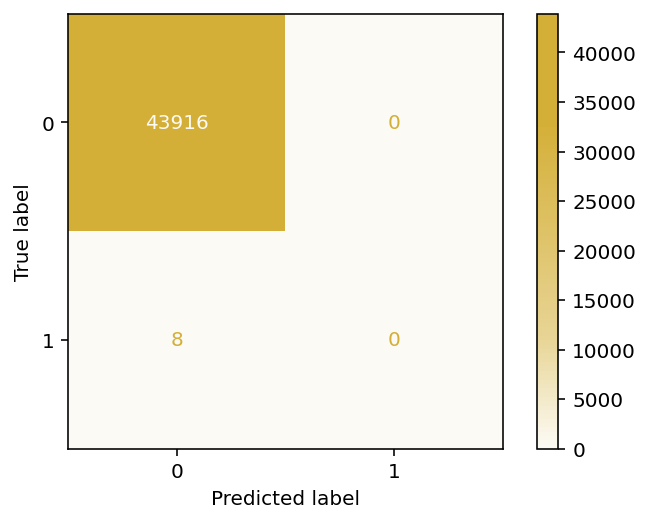

In [156]:
plot_confusion_matrix(svc_bp_win, Z_test, y_test, cmap = golds_cm)
#plt.savefig('../visualizations/cm_svc_nom.png',facecolor=fig.get_facecolor(), edgecolor='none')

### 4.7. Voting Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [157]:
vote_bp_win = VotingClassifier(estimators=[('rf', rfc_bp_win), ('sv', svc_bp_win), ('lr', lr_bp_win)])
vote_bp_win.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(vote_bp_win.score(Z_train, y_train),4)} on train data and {round(vote_bp_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, vote_bp_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, vote_bp_win.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, vote_bp_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, vote_bp_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(vote_bp_win, Z_test, y_test, scoring='precision').mean(),4)}.")

The Voting Classifier has an accuracy of 1.0 on train data and 0.9998 on test data.
The same model has a recall score of 1.0 on train data and 0.0 on test data.
The same model has a precision score of 0.9565 on train data and 0.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9998.
The model's recall calculated in 5-fold cross-validation is 0.0.
The model's precision calculated in 5-fold cross-validation is 0.0.


In [158]:
pickle.dump(vote_bp_win, open('../pickles/vote_bp_win.p', 'wb'))

### 4.8. Stacking Classifier using previously trained Logistic Regression, Random Forest Classifier, and Support Vector Classifier

In [159]:
stack_bp_win = StackingClassifier(estimators=[('rf', rfc_bp_win), ('sv', svc_bp_win), ('lr', lr_bp_win)])
stack_bp_win.fit(Z_train, y_train)

print(f"The Voting Classifier has an accuracy of {round(stack_bp_win.score(Z_train, y_train),4)} on train data and {round(stack_bp_win.score(Z_test, y_test),4)} on test data.")
print(f"The same model has a recall score of {round(recall_score(y_train, stack_bp_win.predict(Z_train)),4)} on train data and {round(recall_score(y_test, stack_bp_win.predict(Z_test)),4)} on test data.")
print(f"The same model has a precision score of {round(precision_score(y_train, stack_bp_win.predict(Z_train)),4)} on train data and {round(precision_score(y_test, stack_bp_win.predict(Z_test)),4)} on test data.")

print(f"The model's accuracy calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp_win, Z_test, y_test).mean(),4)}.")
print(f"The model's recall calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp_win, Z_test, y_test, scoring='recall').mean(),4)}.") 
print(f"The model's precision calculated in 5-fold cross-validation is {round(cross_val_score(stack_bp_win, Z_test, y_test, scoring='precision').mean(),4)}.")

The Voting Classifier has an accuracy of 1.0 on train data and 0.9998 on test data.
The same model has a recall score of 1.0 on train data and 0.0 on test data.
The same model has a precision score of 1.0 on train data and 0.0 on test data.
The model's accuracy calculated in 5-fold cross-validation is 0.9998.
The model's recall calculated in 5-fold cross-validation is 0.0.
The model's precision calculated in 5-fold cross-validation is 0.0.


In [160]:
pickle.dump(stack_bp_win, open('../pickles/stack_bp_win.p', 'wb'))

### 4.9. Picking the best prediction algorightm based on precision and recall

In [161]:
import warnings
warnings.filterwarnings('ignore') 

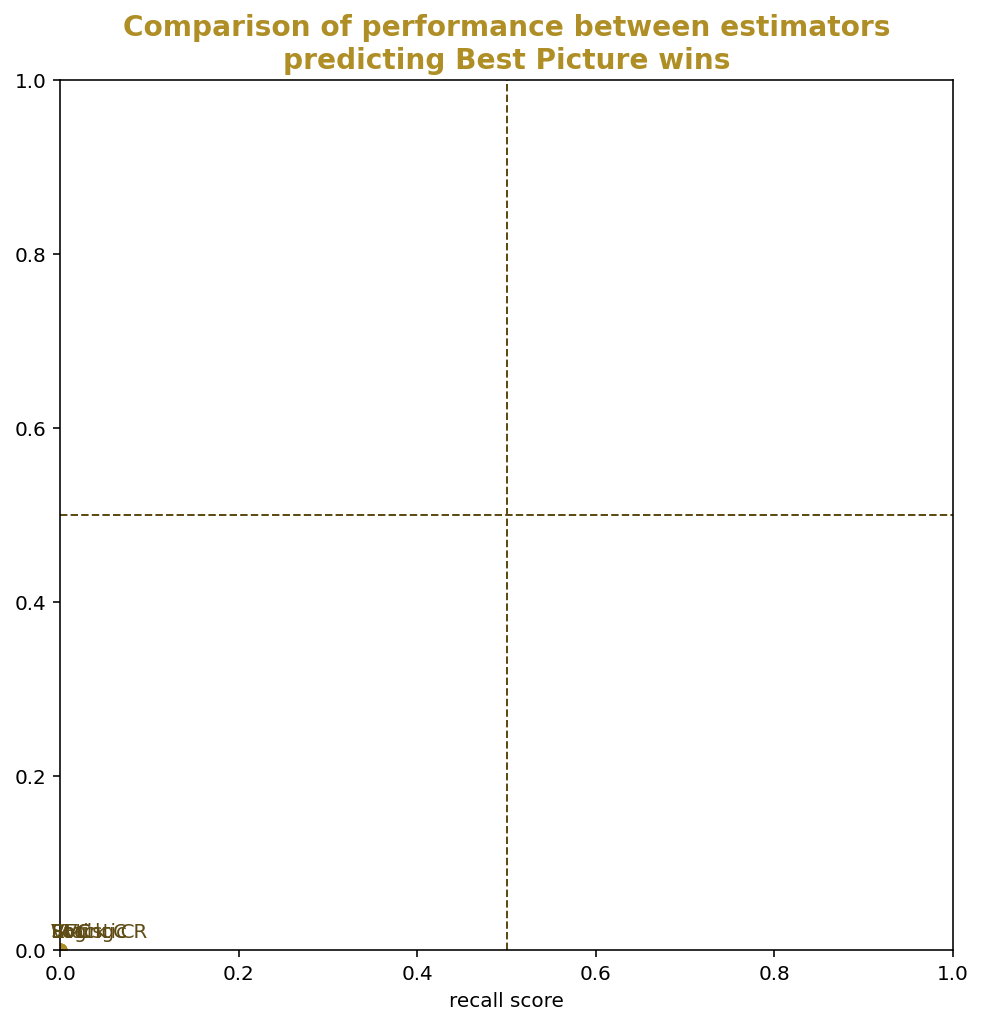

In [162]:
ests_bp_win = [vote_bp_win, stack_bp_win, lr_bp_win, svc_bp_win, rfc_bp_win]
ests_bp_win_labels = ['Voting C', 'Stack C', 'Logistic R', 'SVC', 'RFC']
prec_bp_win = [cross_val_score(estimator, Z_test, y_test, scoring='precision').mean() for estimator in ests_bp_win]
rec_bp_win = [cross_val_score(estimator, Z_test, y_test, scoring='recall').mean() for estimator in ests_bp_win]

plt.figure(figsize = (8,8))
plt.title('Comparison of performance between estimators\npredicting Best Picture wins', fontdict = {'fontsize': 14, 'fontweight': 'bold', 'color': '#ae8e25'})
plt.scatter(prec_bp_win, rec_bp_win, c = '#ae8e25')
plt.xlim(0,1)
plt.xlabel('precision score')
plt.ylim(0,1)
plt.xlabel('recall score')
plt.axhline(0.5, ls = '--', lw = 1, c = '#5e4c14')
plt.axvline(0.5, ls = '--', lw = 1, c = '#5e4c14')
for i in range(len(ests_bp_win)):
    plt.text(prec_bp_win[i]-0.01, rec_bp_win[i]+0.015, ests_bp_win_labels[i], c = '#5e4c14')

***